# A numerical study of fixation probabilities for strategies in the Prisoners  Dilemma

This notebook contains all the Python code used to generate the plots and figures for the paper.

Here are the versions of the various libraries used:

In [160]:
%matplotlib inline

import axelrod as axl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math
import imp
players = imp.load_source('players', '../src/players.py')
generate_cache = imp.load_source('players', '../src/generate_cache.py')
theoretic = imp.load_source('theoretic', '../src/theoretic.py')

assert axl.__version__ == '2.9.0' 
assert pd.__version__ == '0.19.2'
assert matplotlib.__version__ == '2.0.0'
assert sns.__version__ == '0.7.1'
assert np.__version__ == '1.12.1'

## Description of the used strategies

Here are all the strategies used in this experiment:

In [161]:
from players import selected_players
players = selected_players()

assert len(players) == 172

In [162]:
players

[Adaptive,
 Adaptive Tit For Tat: 0.5,
 Aggravater,
 ALLCorALLD,
 Alternator,
 Alternator Hunter,
 AntiCycler,
 Anti Tit For Tat,
 Adaptive Pavlov 2006,
 Adaptive Pavlov 2011,
 Appeaser,
 Arrogant QLearner,
 Average Copier,
 Better and Better,
 BackStabber: ('D', 'D'),
 Bully,
 Calculator,
 Cautious QLearner,
 Champion,
 CollectiveStrategy,
 Contrite Tit For Tat,
 Cooperator,
 Cooperator Hunter,
 Cycle Hunter,
 Cycler CCCCCD,
 Cycler CCCD,
 Cycler CCD,
 Cycler DC,
 Cycler DDC,
 Cycler CCCDCD,
 Davis: 10,
 Defector,
 Defector Hunter,
 Desperate,
 DoubleCrosser: ('D', 'D'),
 Doubler,
 EasyGo,
 Eatherley,
 Eventual Cycle Hunter,
 Evolved ANN,
 Evolved ANN 5,
 Evolved ANN 5 Noise 05,
 Evolved FSM 4,
 Evolved FSM 16,
 Evolved FSM 16 Noise 05,
 EvolvedLookerUp1_1_1,
 EvolvedLookerUp2_2_2,
 Evolved HMM 5,
 Feld: 1.0, 0.5, 200,
 Firm But Fair,
 Fool Me Forever,
 Fool Me Once,
 Forgetful Fool Me Once: 0.05,
 Forgetful Grudger,
 Forgiver,
 Forgiving Tit For Tat,
 Fortress3,
 Fortress4,
 GTFT: 0.

In [163]:
with open("../tbl/list_of_players.tex", "w") as f:
    for player in players:
        latex_name = "{}\n".format(player).replace("_", "\_")
        f.write("\item {}".format(latex_name))

Here are some summary information about the strategies

In [204]:
def clean_mem(n):
    try:
        return int(n)
    except OverflowError:
        return -1

player_info = pd.DataFrame([[str(p), p.classifier["stochastic"], clean_mem(p.classifier['memory_depth'])] 
                        for p in players], 
                       columns=["Player", "Stochastic", "Memory Depth"])

In [205]:
temp_df = pd.DataFrame(player_info.groupby("Stochastic")["Player"].count()).reset_index().rename(columns={"Player": "Count"})
temp_df

Stochastic  Count
0      False    123
1       True     49

In [208]:
with open("../tbl/stochastic_count.tex", "w") as f:
    f.write(temp_df.to_latex(index=False))

In [209]:
temp_df = pd.DataFrame(player_info.groupby("Memory Depth")["Player"].count()).transpose()
temp_df.rename(index={"Player": "Count"}, inplace=True)
cols = temp_df.columns.tolist()
temp_df = temp_df[cols[1:] + [cols[0]]]
temp_df

Memory Depth   0     1     2     3     4     5     6     9     10    11   \
Count            3    31    12     8     2     6     1     1     5     1   

Memory Depth   12    16    20    40    200  -1    
Count            1     2     2     2     1    94

In [210]:
with open("../tbl/memory_depth_count.tex", "w") as f:
    string = temp_df.to_latex().replace("-1", "\(\infty\)")
    f.write(string)

## Illustrating the Approximate moran process

In [169]:
cached_outcomes = pd.read_csv("../data/outcomes.csv", header=None, 
                              names=["Player 1", "Player 2", "Score 1", "Score 2", "Iteration"])

Get the counts of each number of 

In [170]:
temp_df = pd.DataFrame(cached_outcomes.groupby(["Player 1", "Player 2"]).count()).reset_index()

In [172]:
max_pair = temp_df.iloc[temp_df["Score 1"].idxmax()][:2]
max_pair

Player 1            Risky QLearner
Player 2    Meta Hunter: 6 players
Name: 13103, dtype: object

In [173]:
min_pair = temp_df.iloc[temp_df["Score 1"].idxmin()][:2]
min_pair

Player 1    $\phi$
Player 2    $\phi$
Name: 0, dtype: object

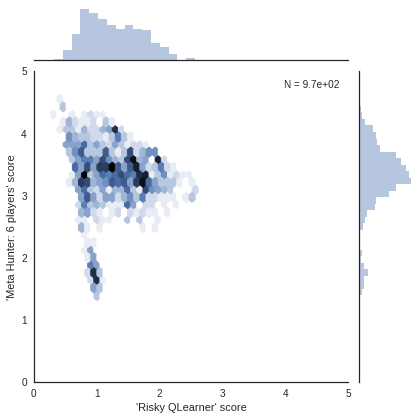

In [175]:
temp_df = cached_outcomes[(cached_outcomes["Player 1"] == max_pair[0]) & (cached_outcomes["Player 2"] == max_pair[1])]

def N(x, y):
    return len(x)

sns.set(style="white", color_codes=True)
ax = sns.jointplot(temp_df["Score 1"], temp_df["Score 2"], stat_func=N, 
                   kind="hex", xlim=(0, 5), ylim=(0,5))
ax.set_axis_labels(*["\'{}\' score".format(max_pair[i][:25]) for i in range(2)])
ax.savefig("../img/players_with_most_scores.pdf");

In [177]:
len(temp_df["Score 1"])

971

## Validating the model

Here we create a number of plots comparing the theoretic fixation probability with the observed fixation probability.

In [179]:
validation = pd.read_csv("../data/fixation_validation.csv")

/home/vince/anaconda3/envs/moran/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


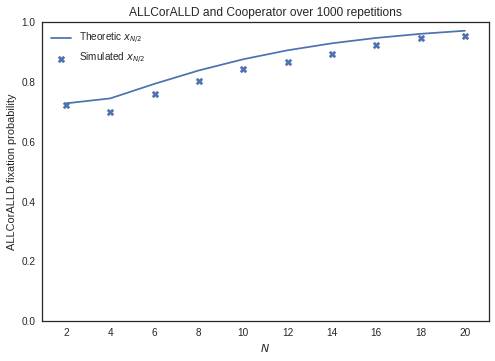

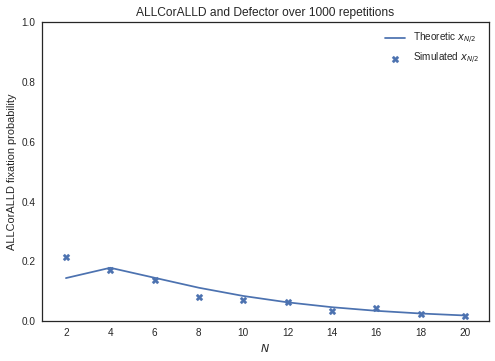

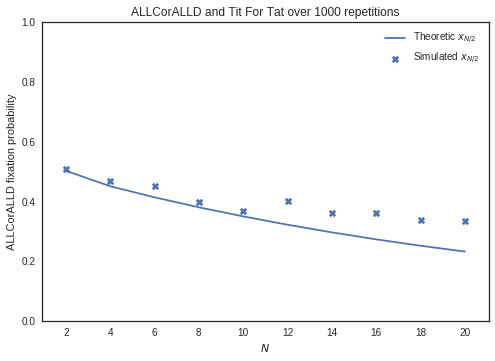

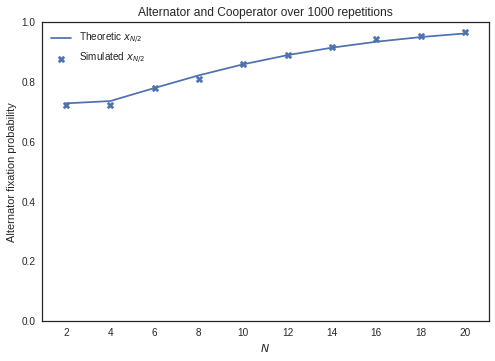

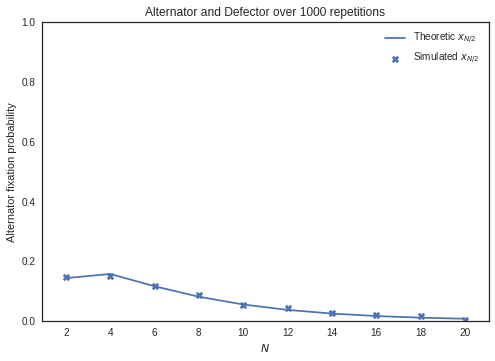

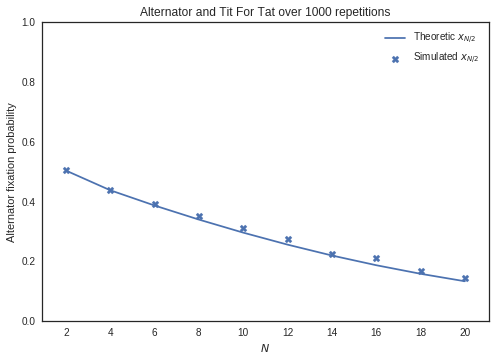

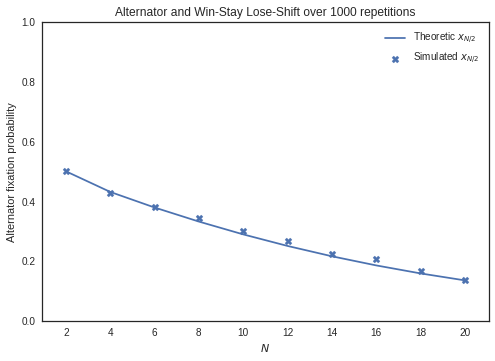

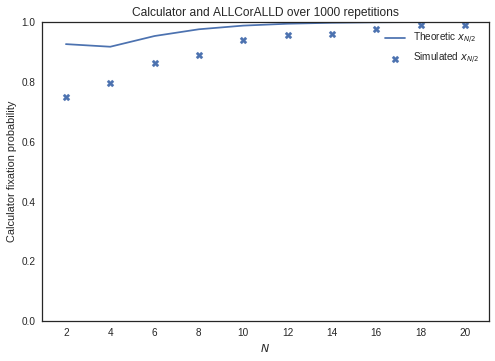

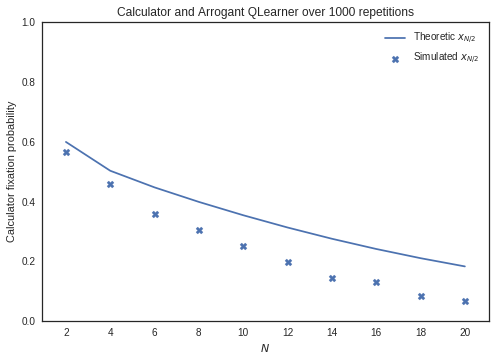

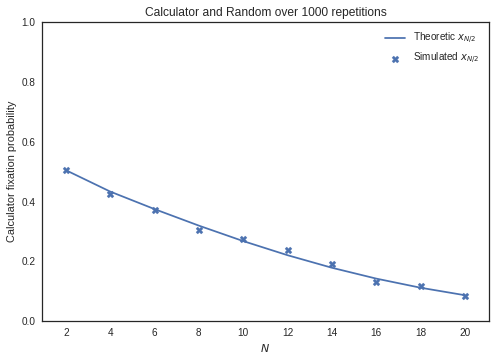

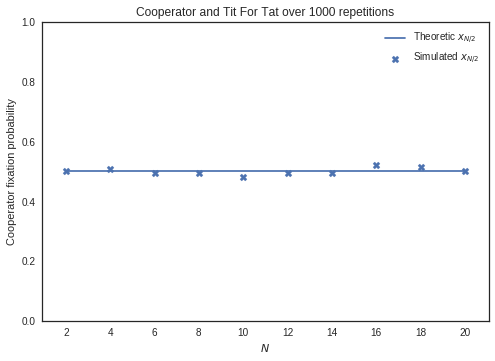

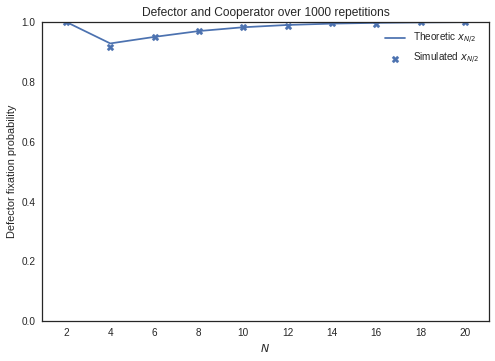

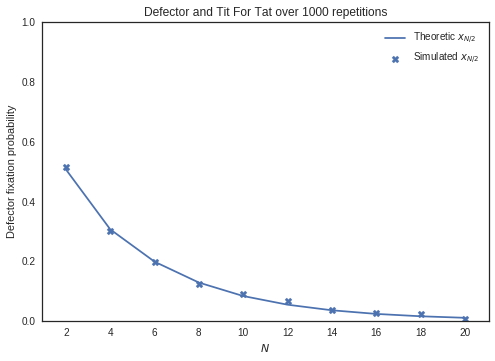

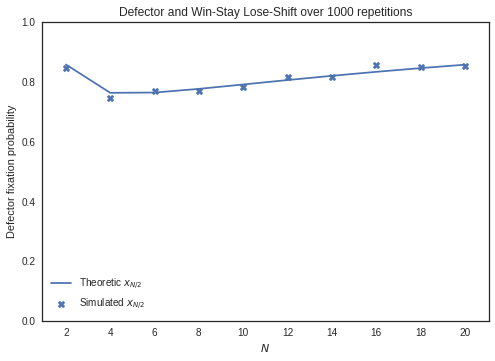

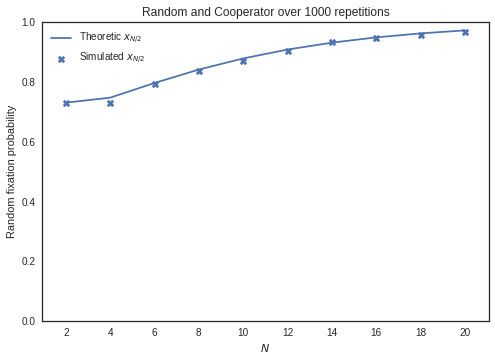

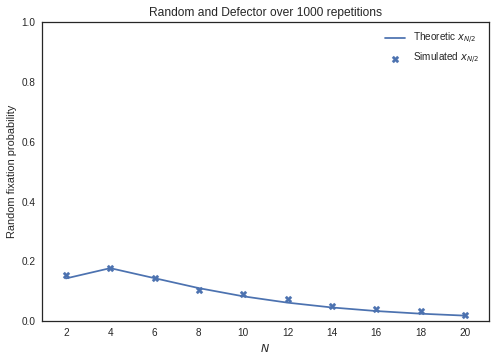

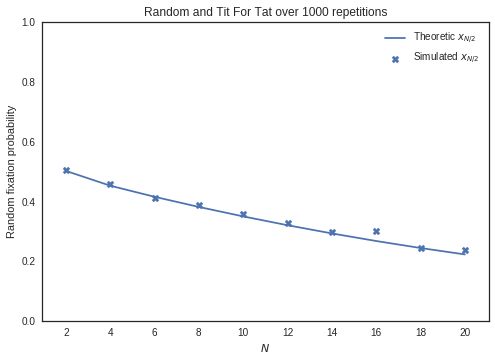

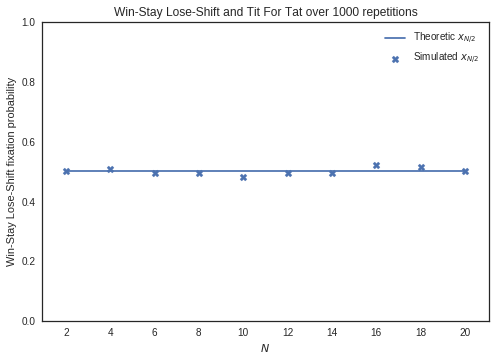

In [180]:
all_player_names = [p.__repr__() for p in players]
for names, df in validation.groupby(["Player 1", "Player 2"]):
    
    df.sort_values("N", inplace=True)
    
    repetitions = df["Repetitions"].iloc[0]
    assert all(df["Repetitions"] == repetitions)
    
    # Get names instead of repr (to drop some parameters)
    names = [players[all_player_names.index(name)].name 
             for name in names]
    title = "{} and {} over {} repetitions".format(*names, repetitions)
    filename = "{}_v_{}".format(*names)

    for substr in [": ", ".", ":", " "]:
        filename = filename.replace(substr, "_")
    
    plt.figure()
    plt.plot(df["N"], df["Theoretic"], label="Theoretic $x_{N/2}$")
    plt.scatter(df["N"], df["Simulated"], label="Simulated $x_{N/2}$",
                marker="X")
    plt.xticks(df["N"])
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel("{} fixation probability".format(names[0]))
    plt.xlabel("$N$")
    plt.legend()
    plt.savefig("../img/{}.pdf".format(filename))

# Carry out analysis of Moran processes

In [182]:
summary = pd.read_csv("../data/sims_summary.csv")

In [183]:
summary.head()

P1     P2  N  Noise  Repetitions  P1 fixation  P2 fixation
0  $\phi$  $\pi$  2  False         2000       0.8520       0.1480
1  $\phi$  $\pi$  2   True         2000       0.7990       0.2010
2  $\phi$  $\pi$  4  False         2000       0.8835       0.1165
3  $\phi$  $\pi$  4   True         2000       0.8395       0.1605
4  $\phi$  $\pi$  6  False         2000       0.9330       0.0670

### Median fixation probability for each strategy

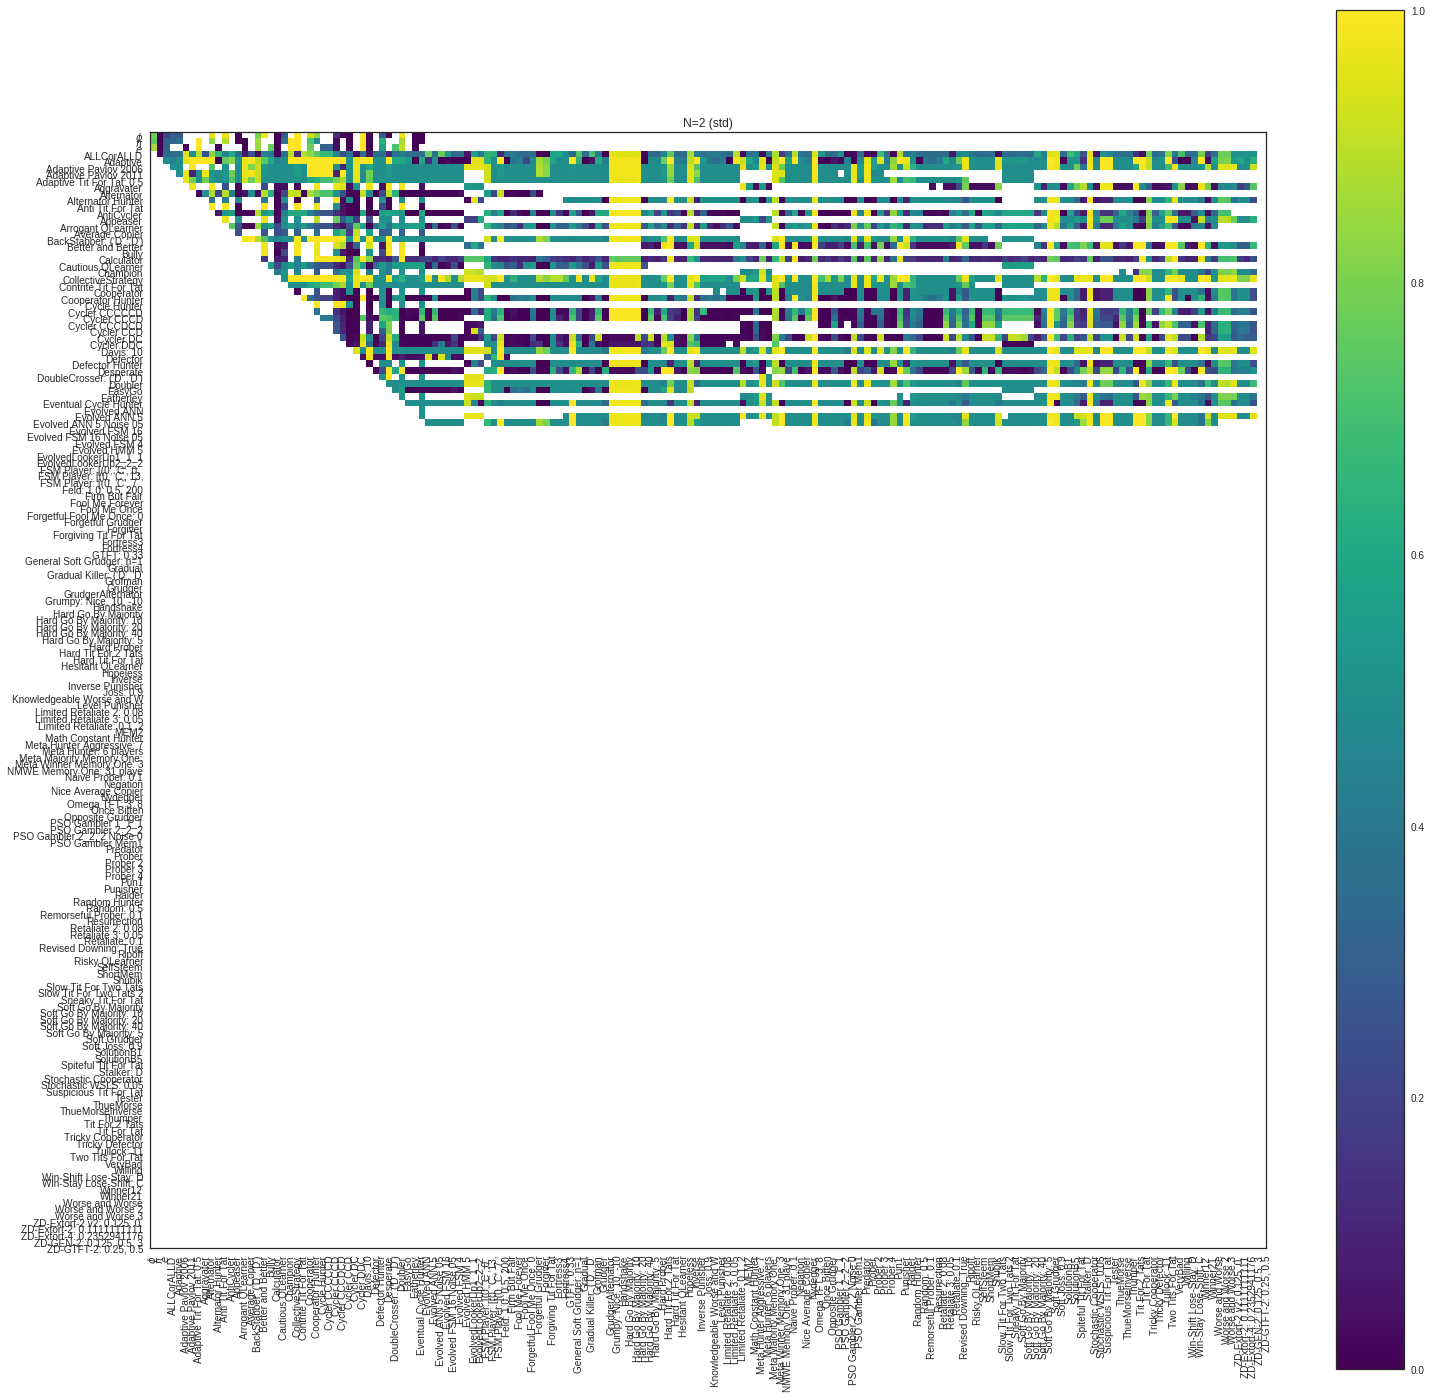

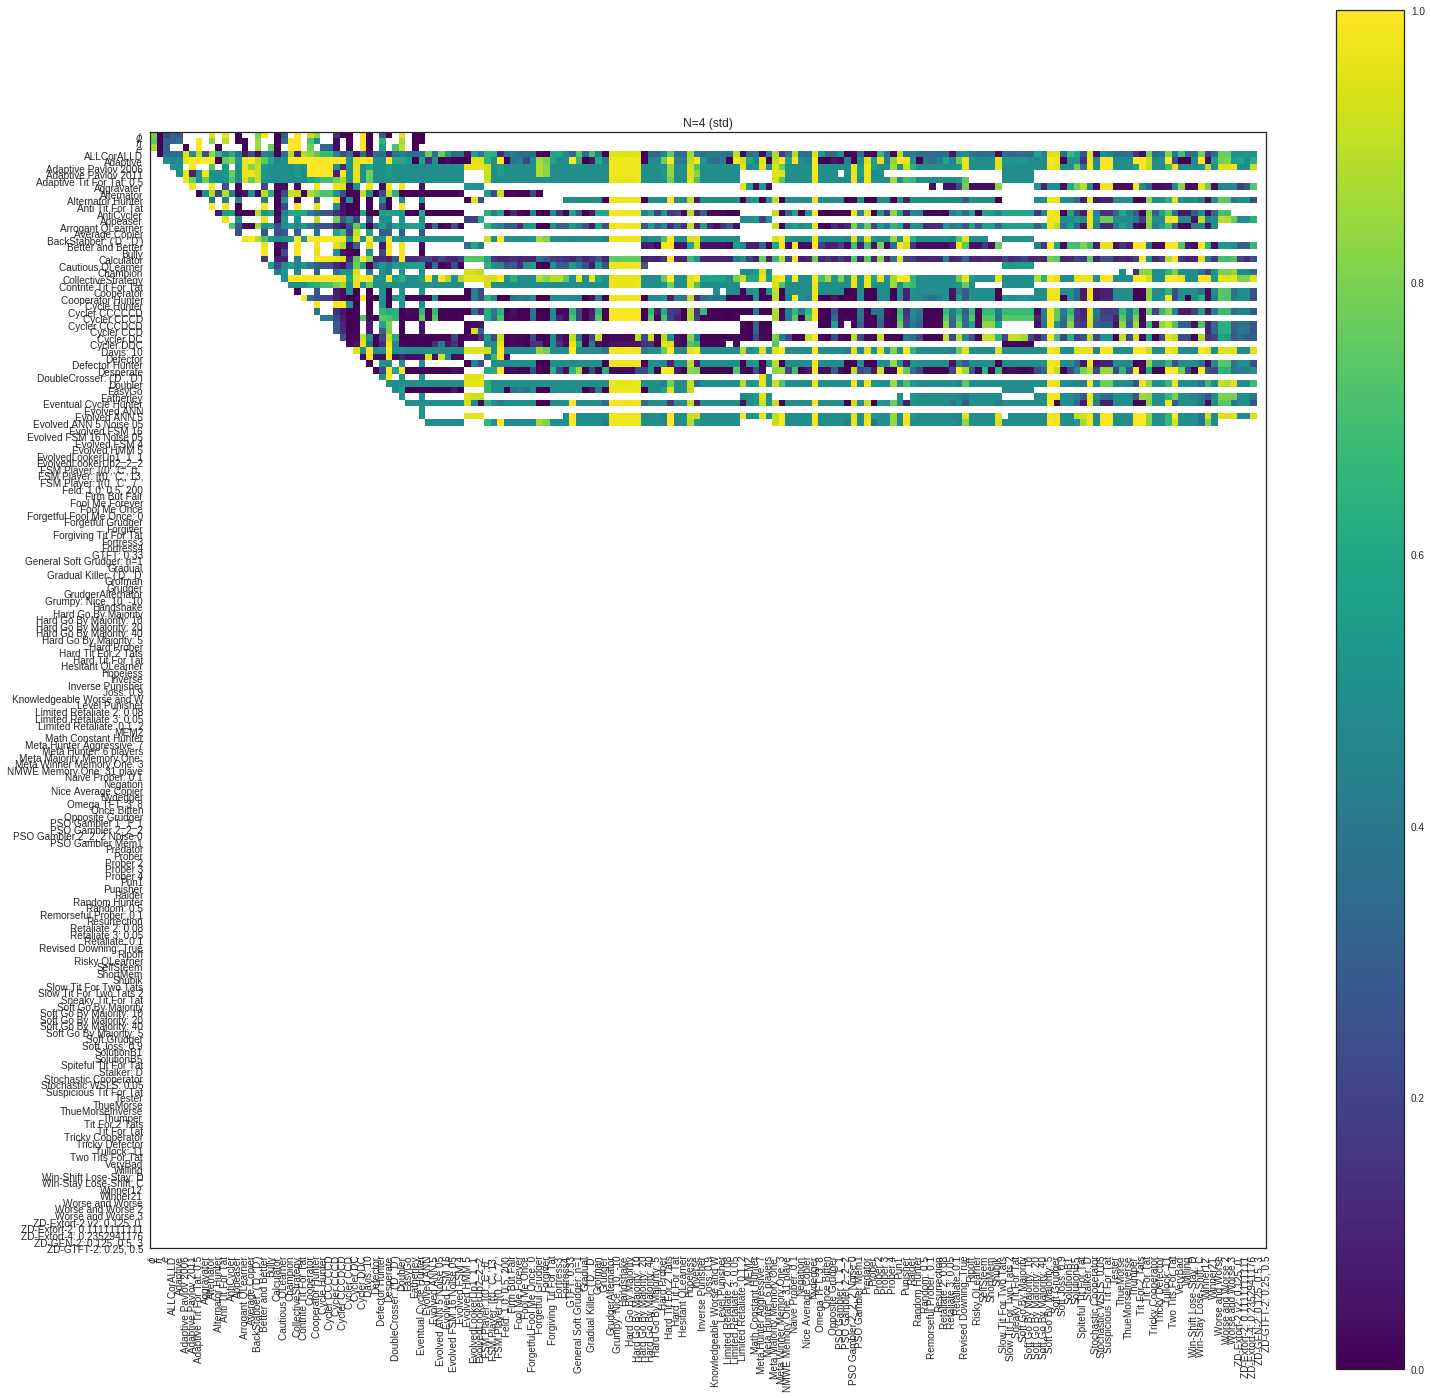

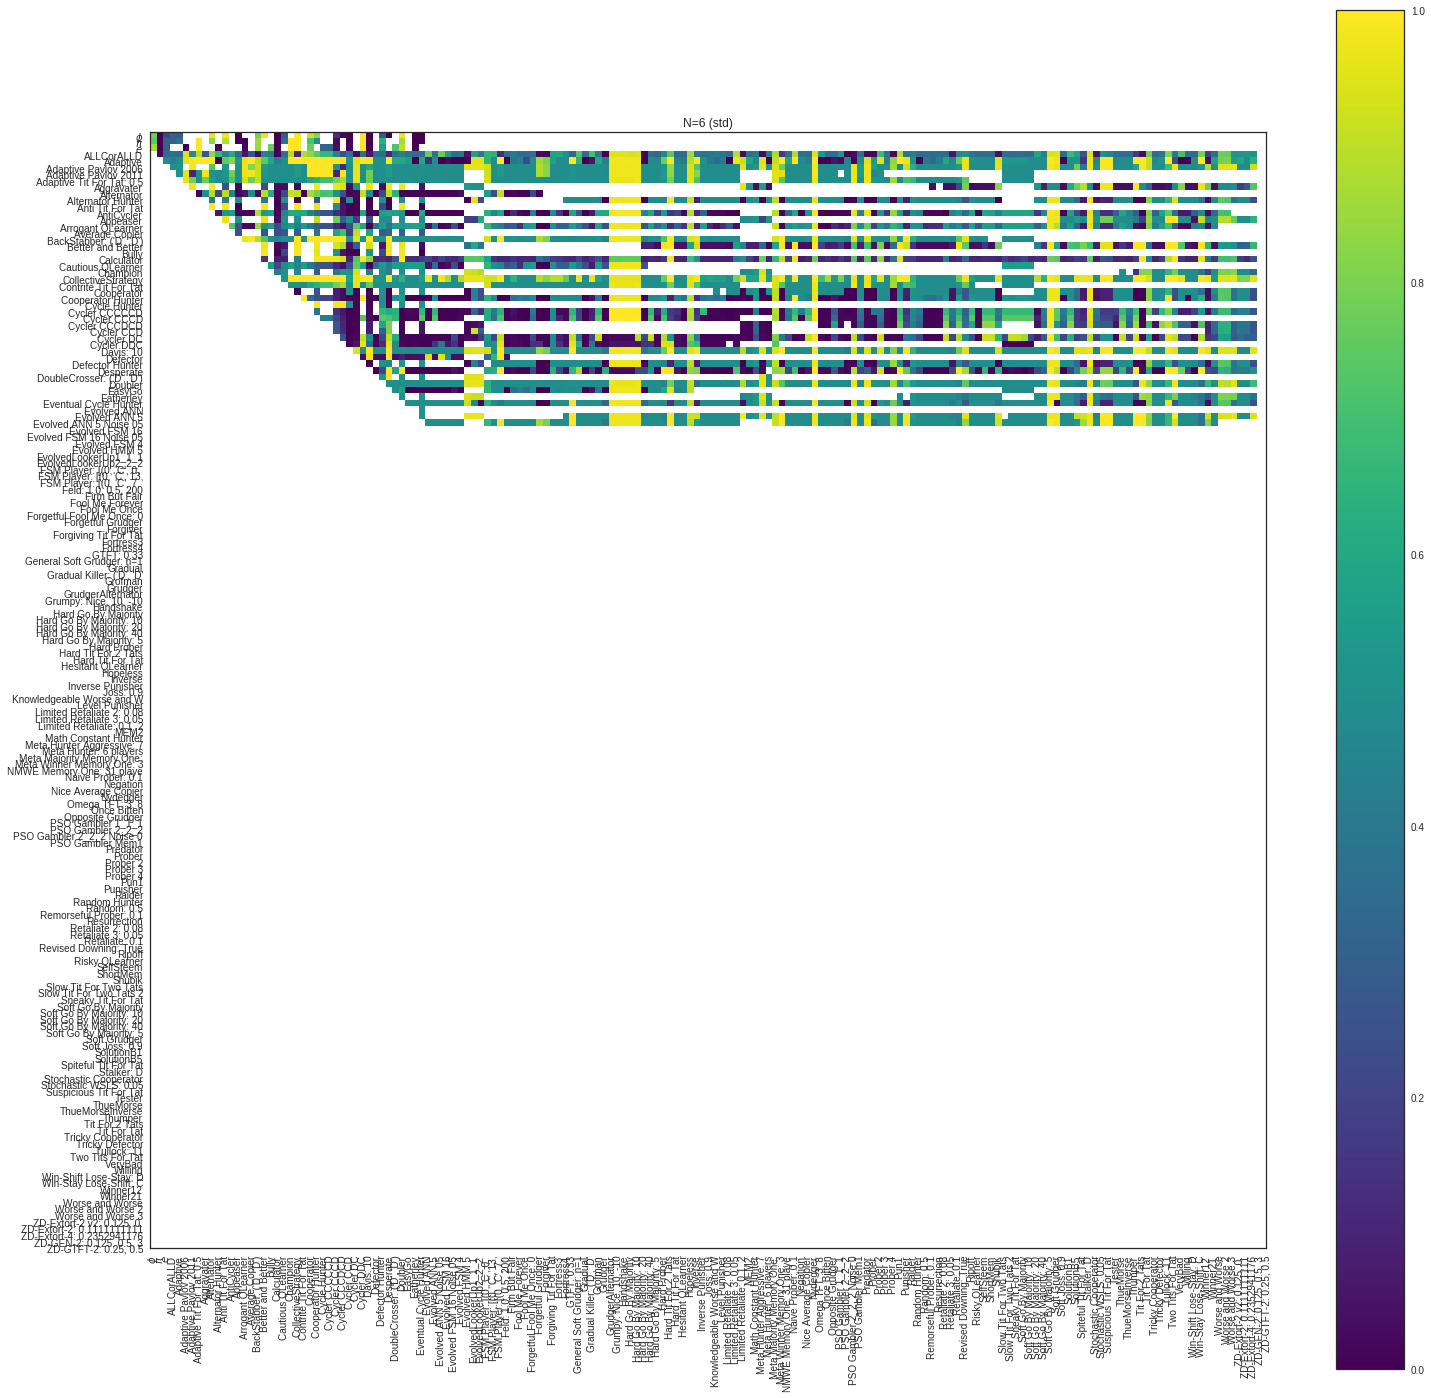

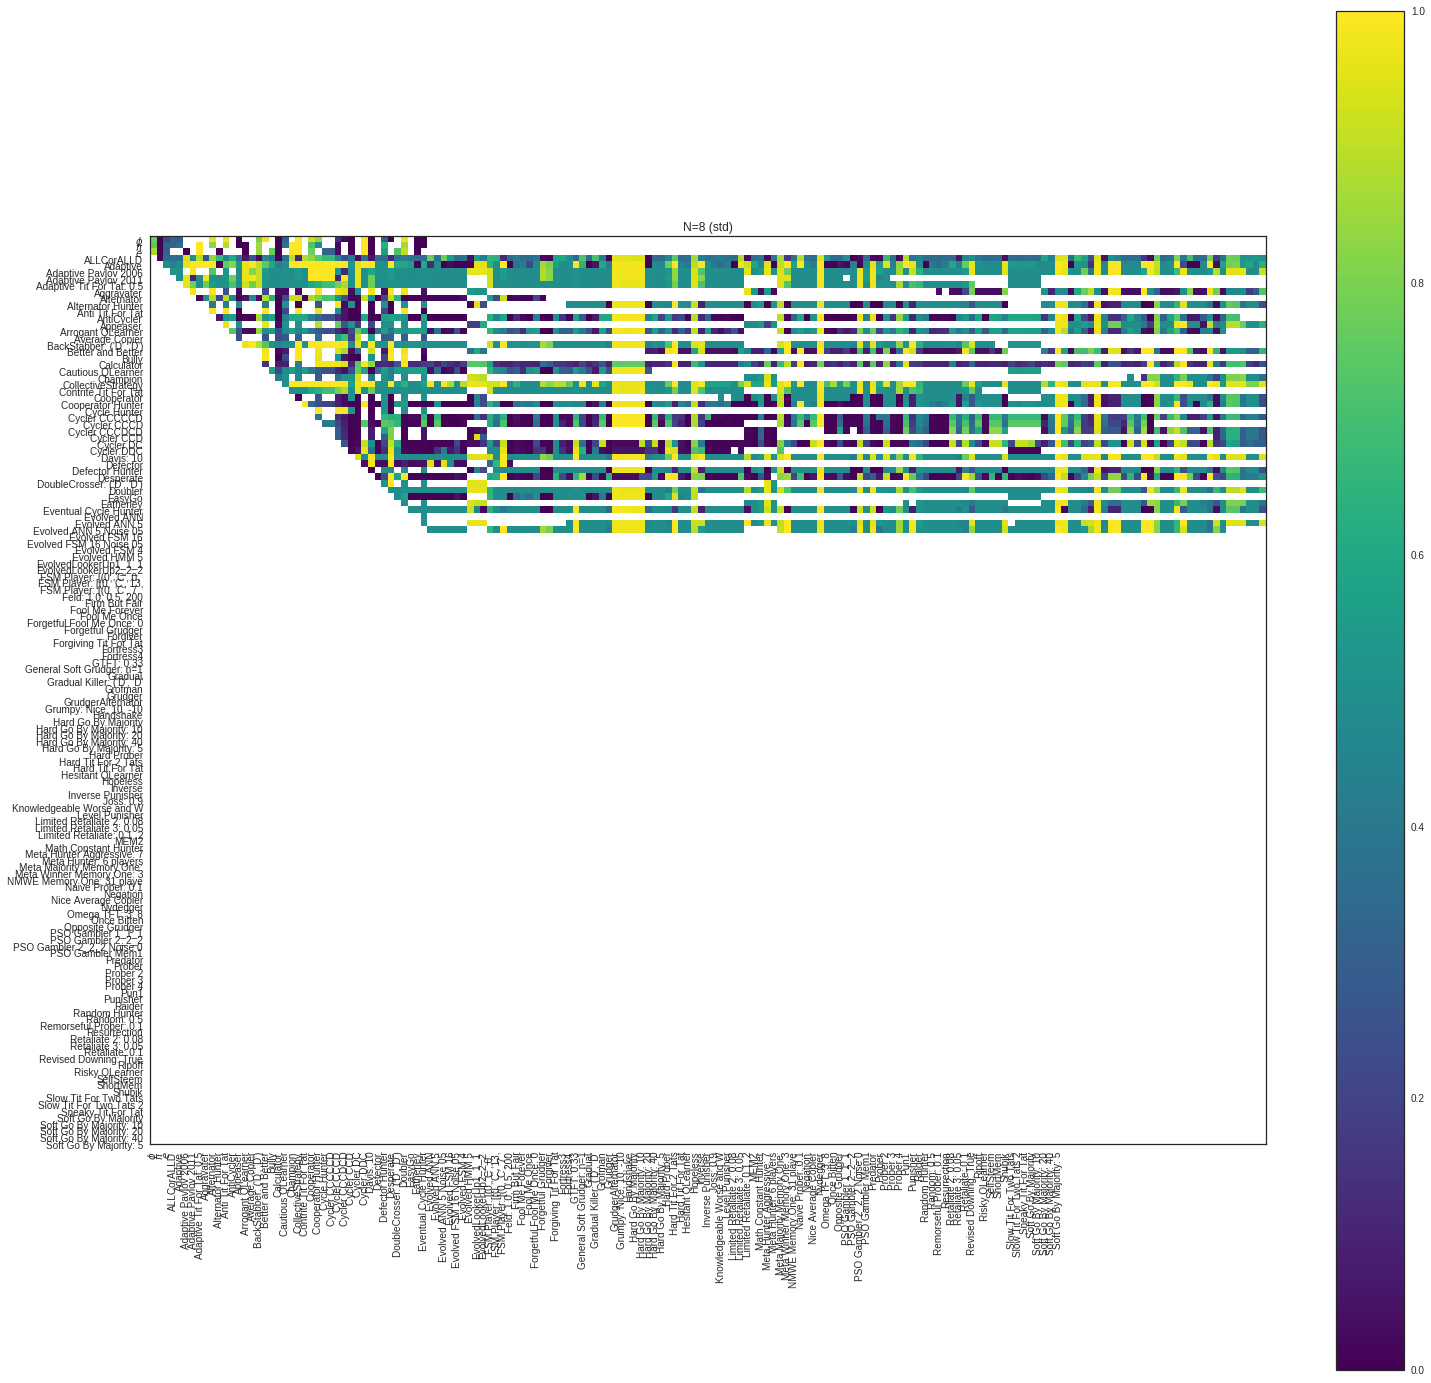

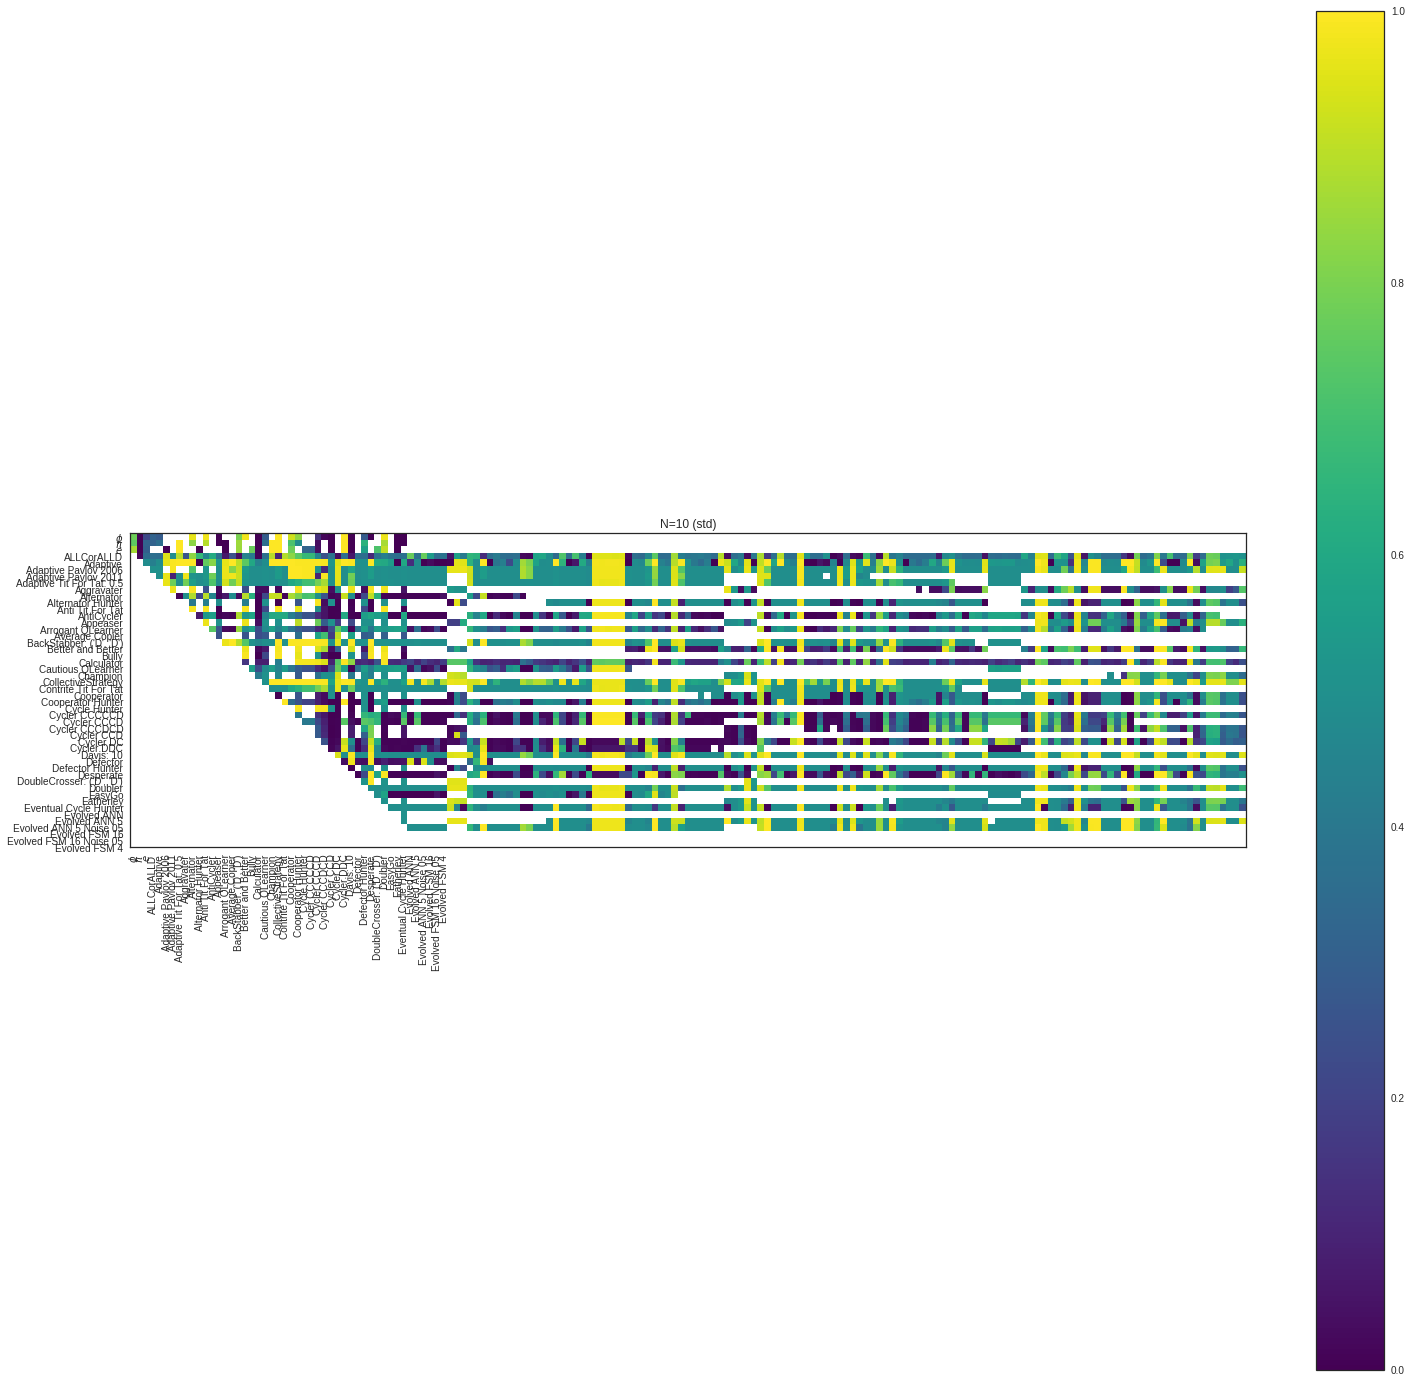

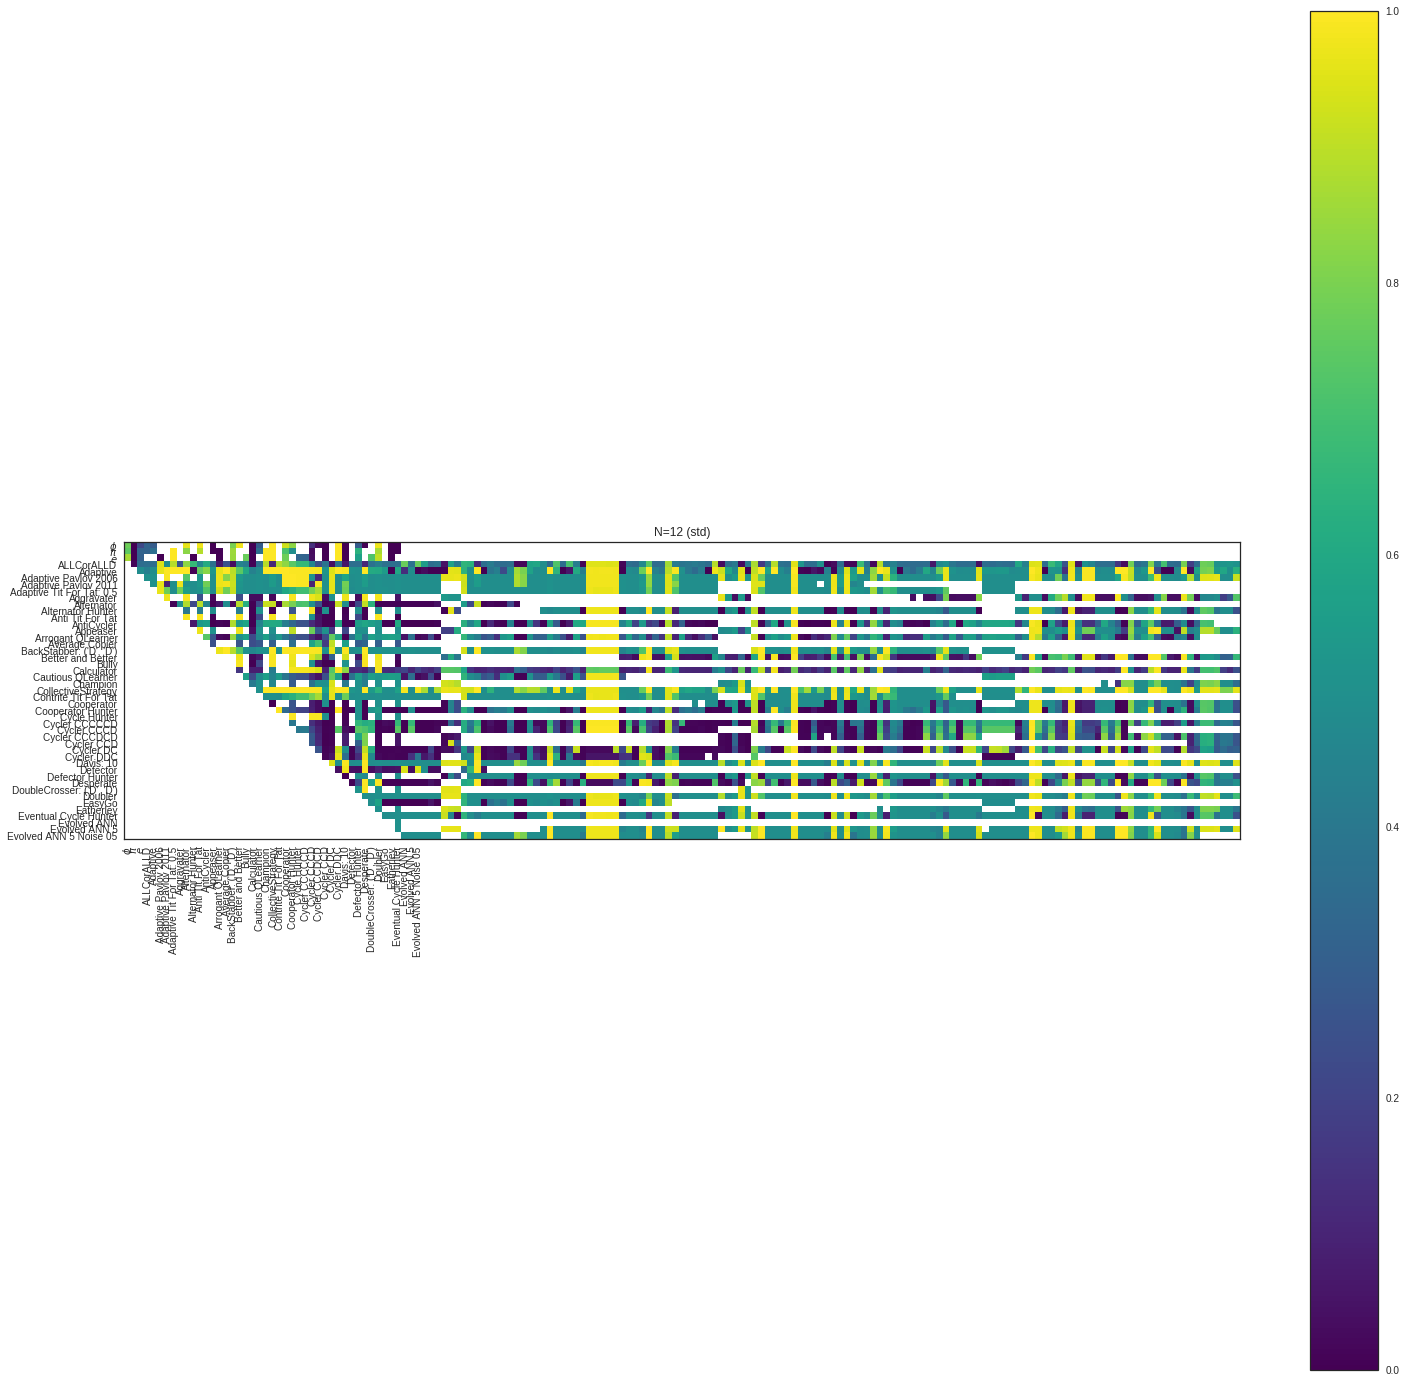

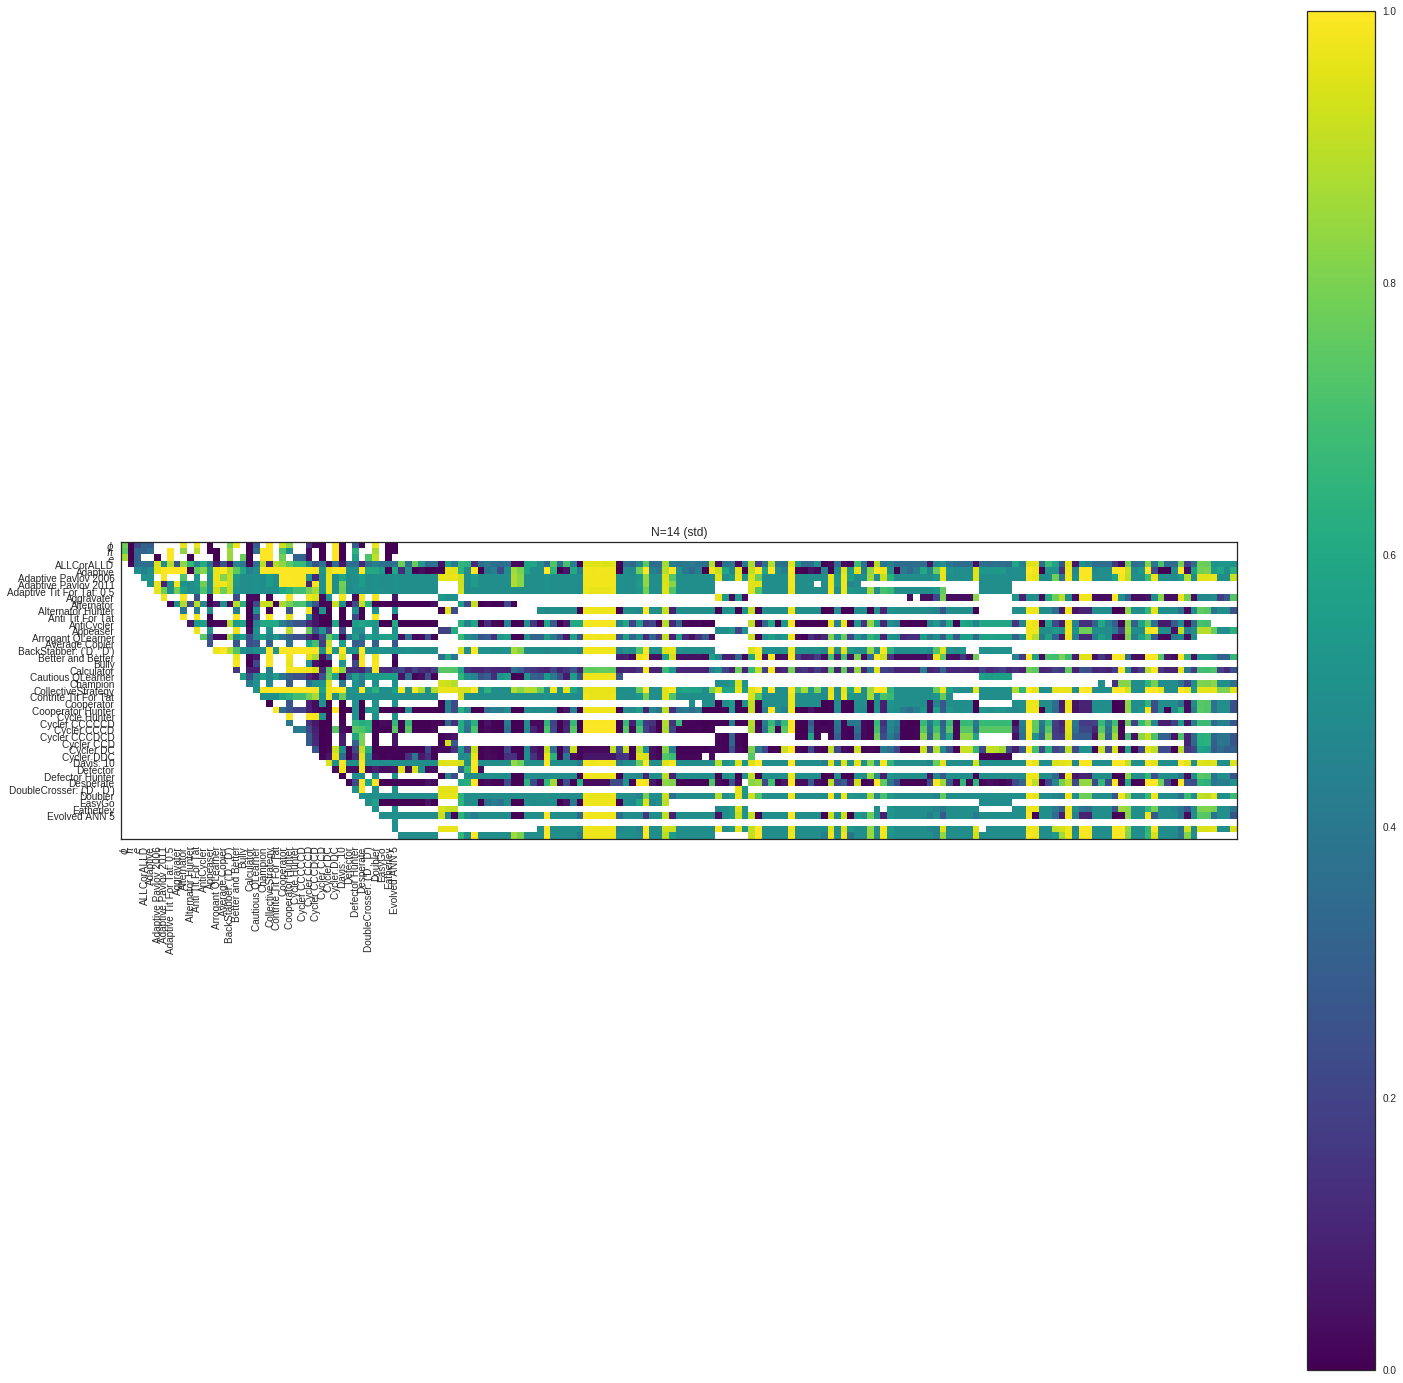

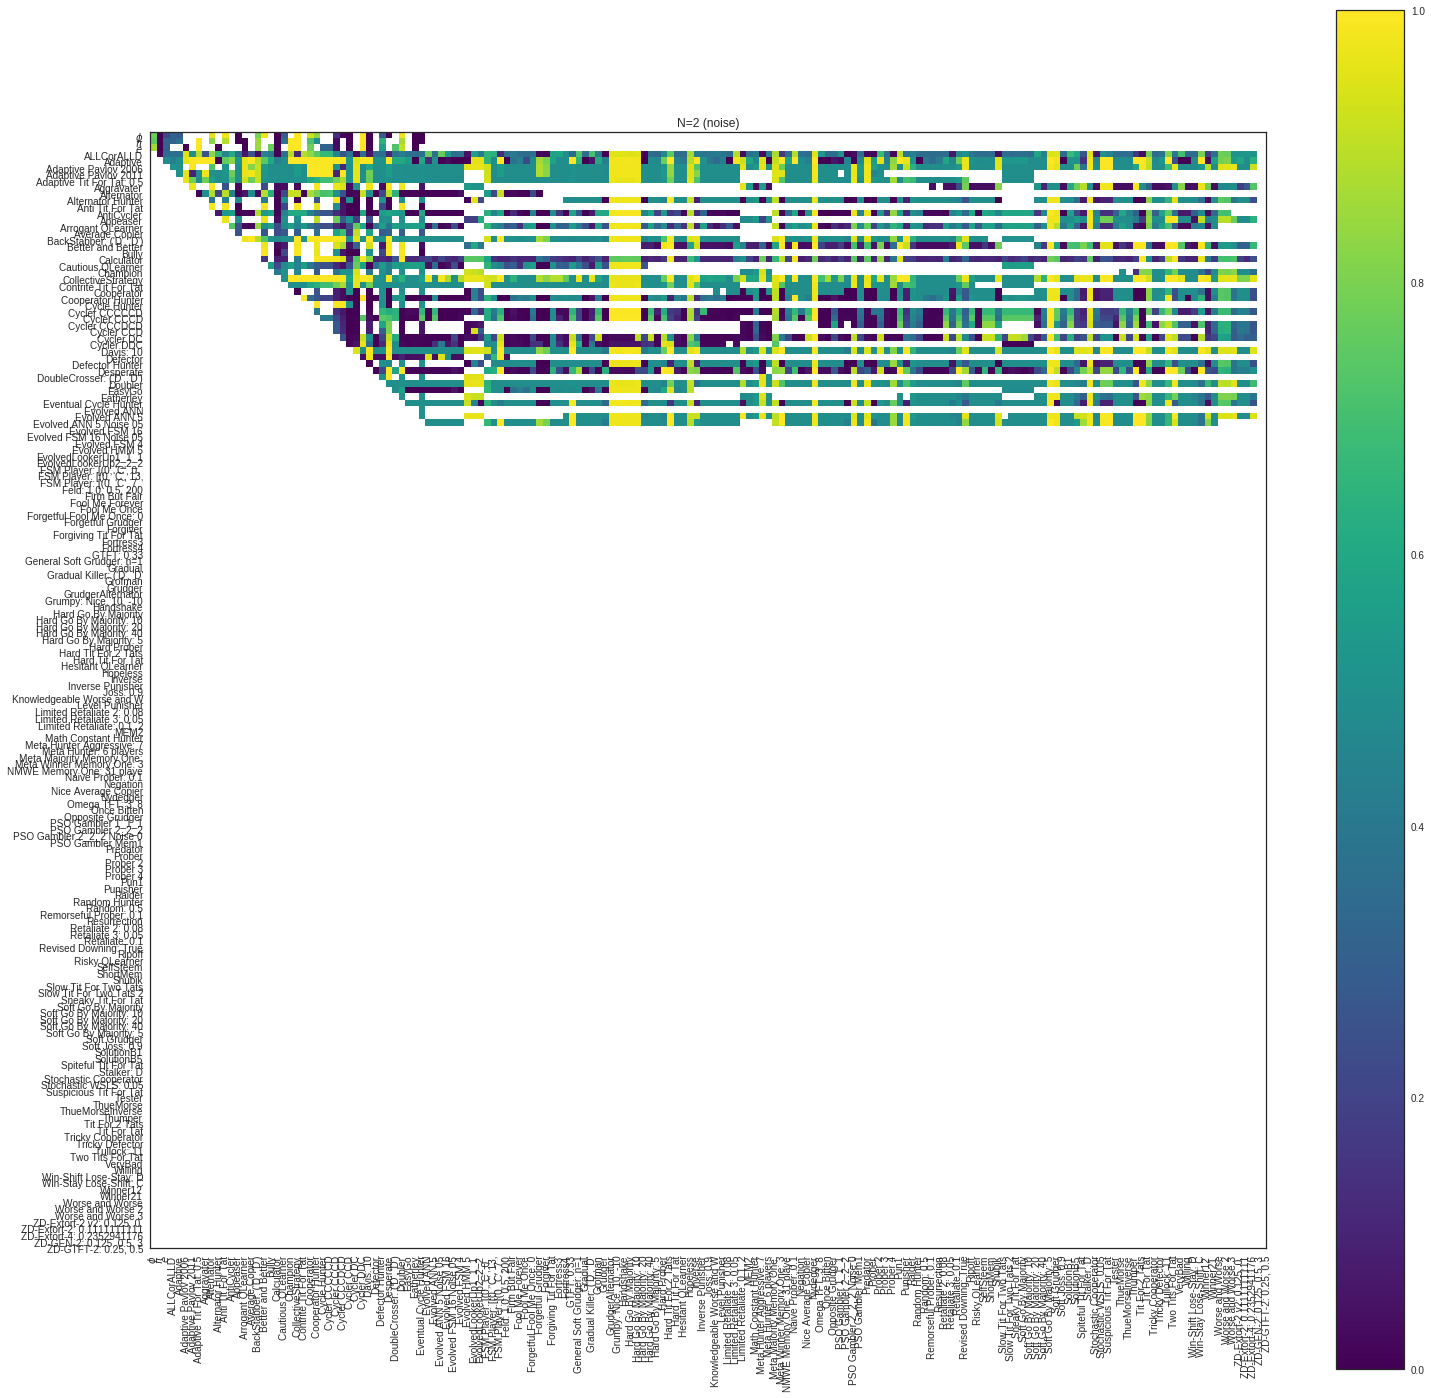

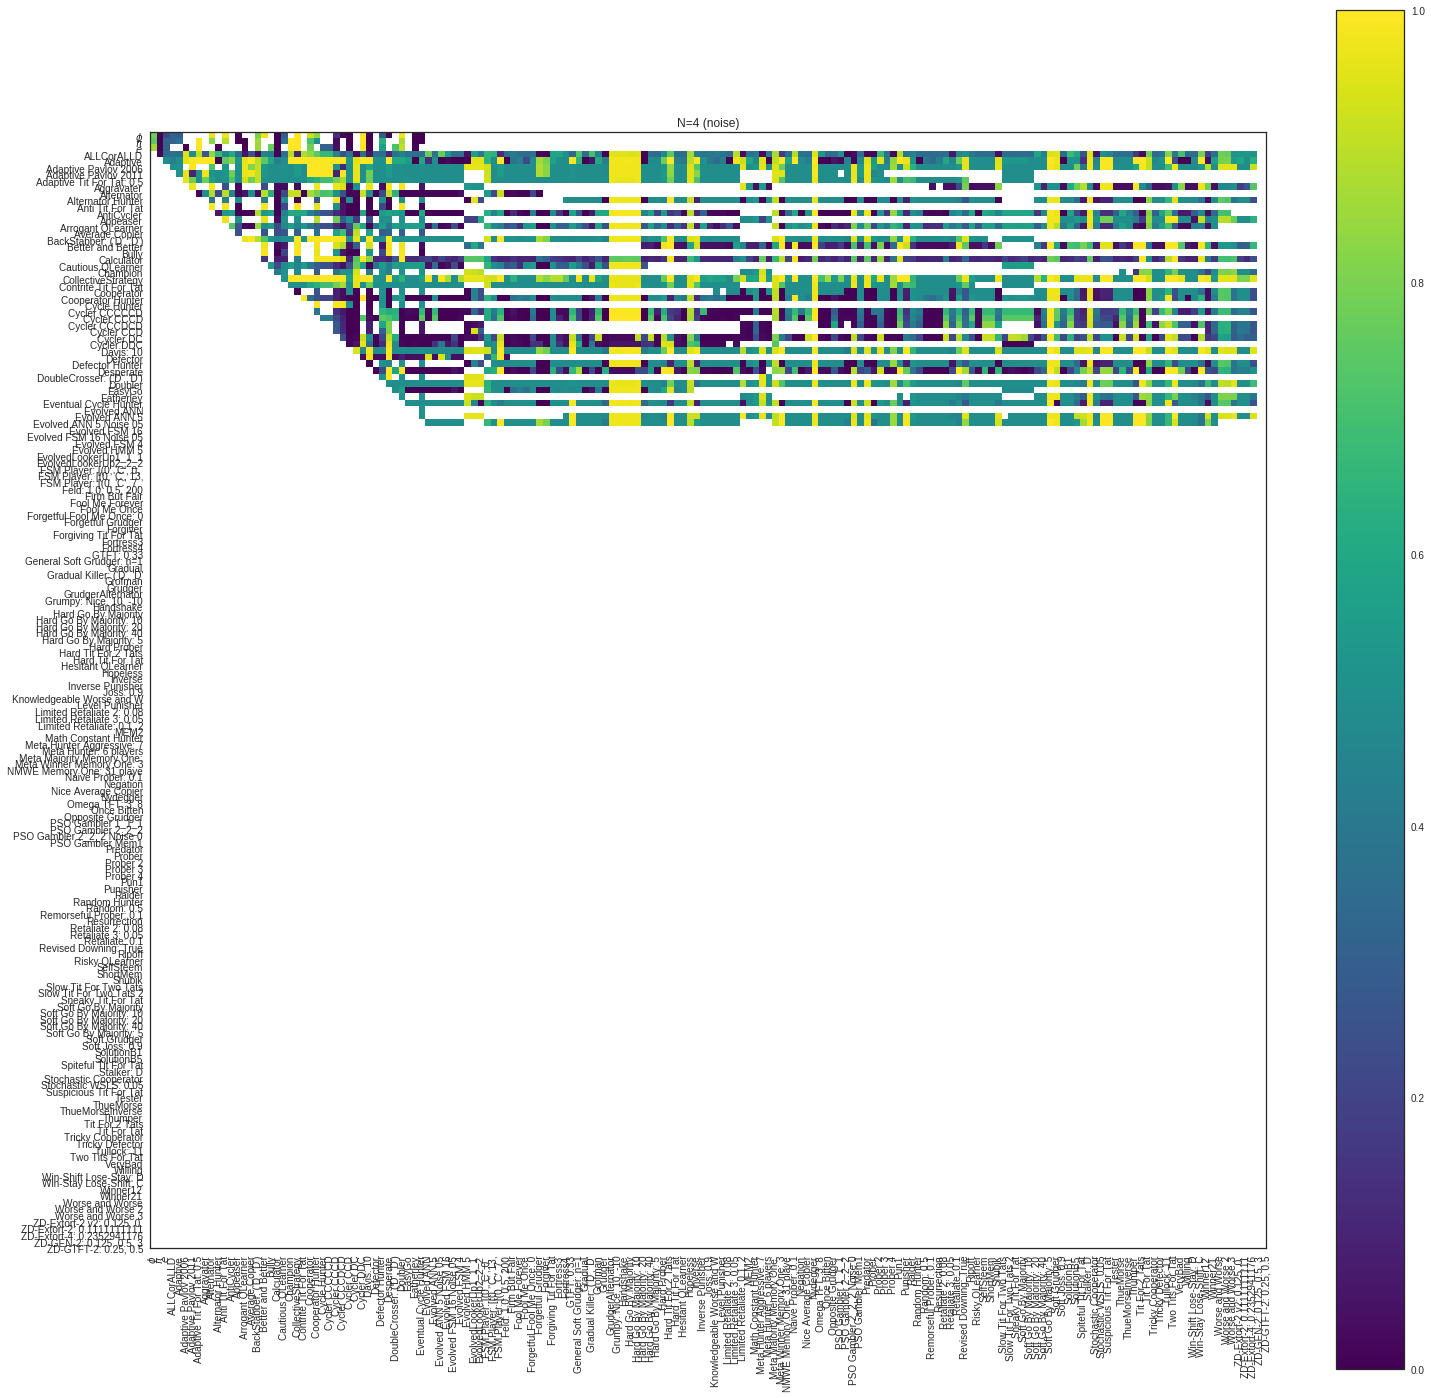

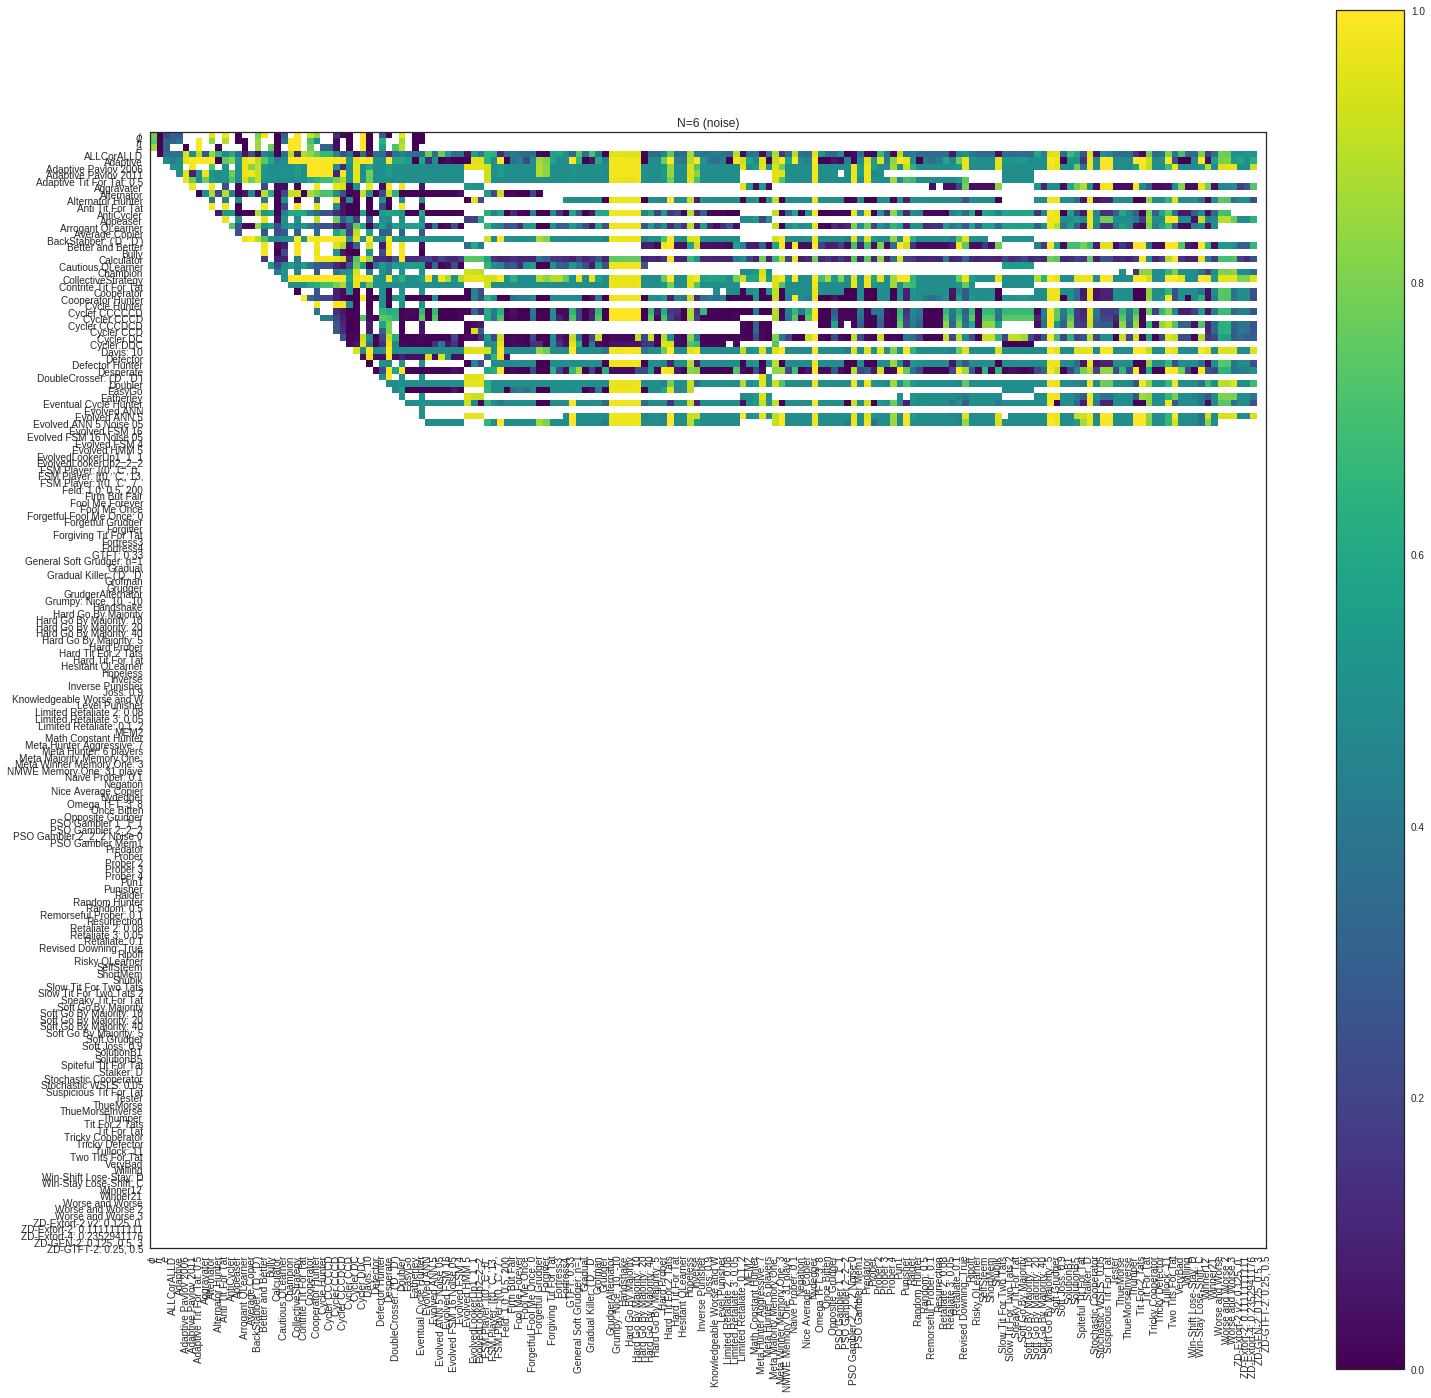

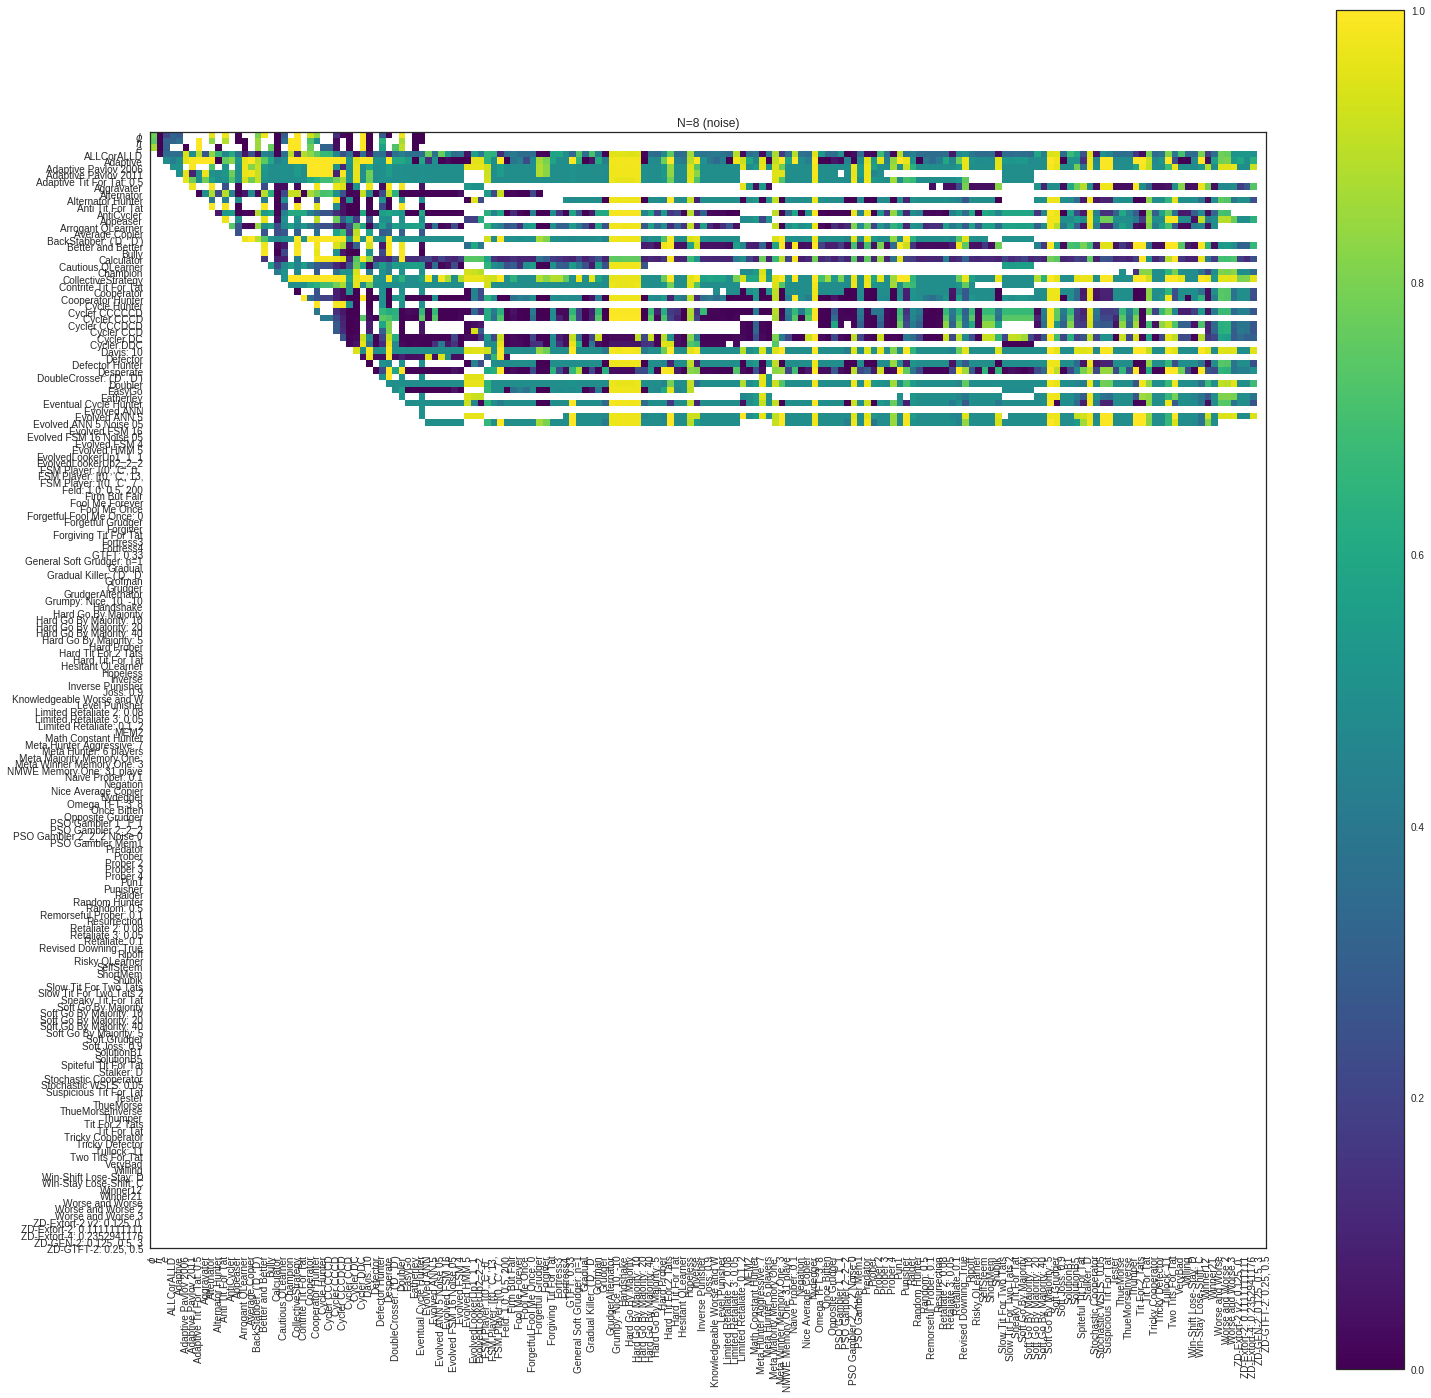

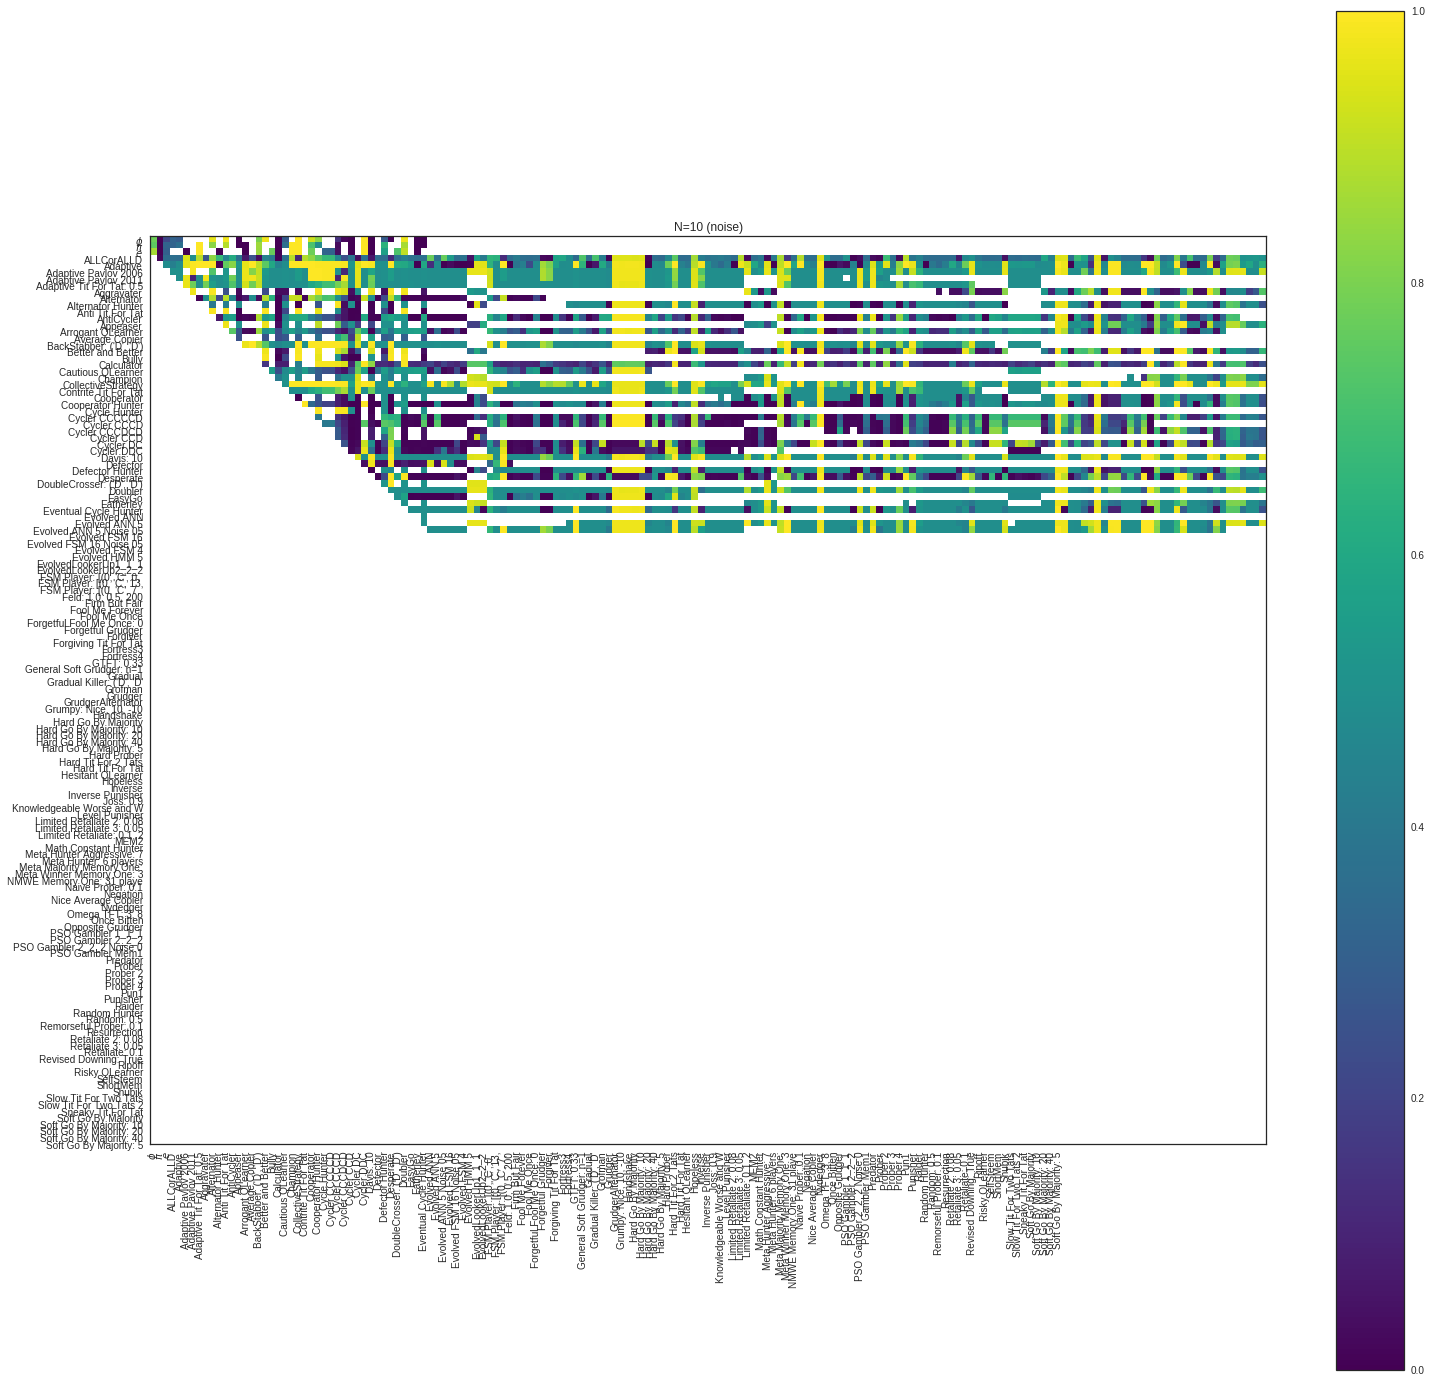

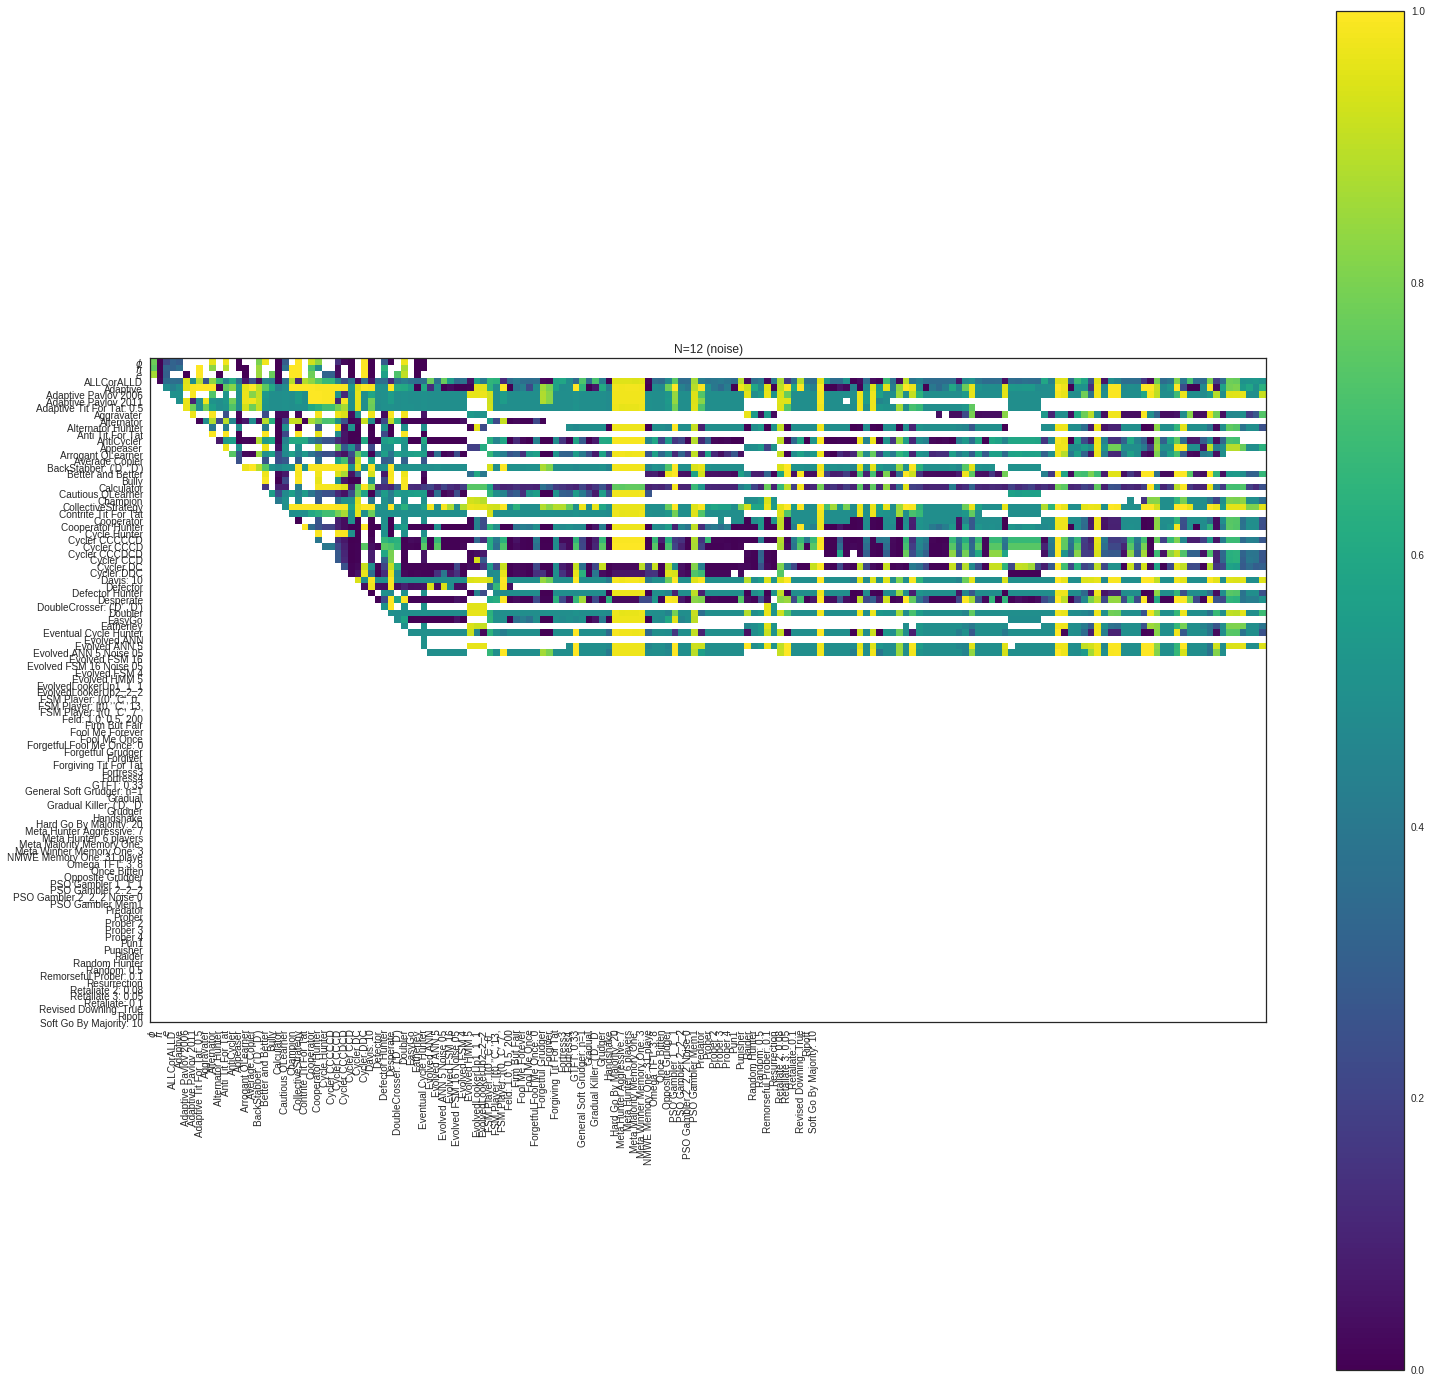

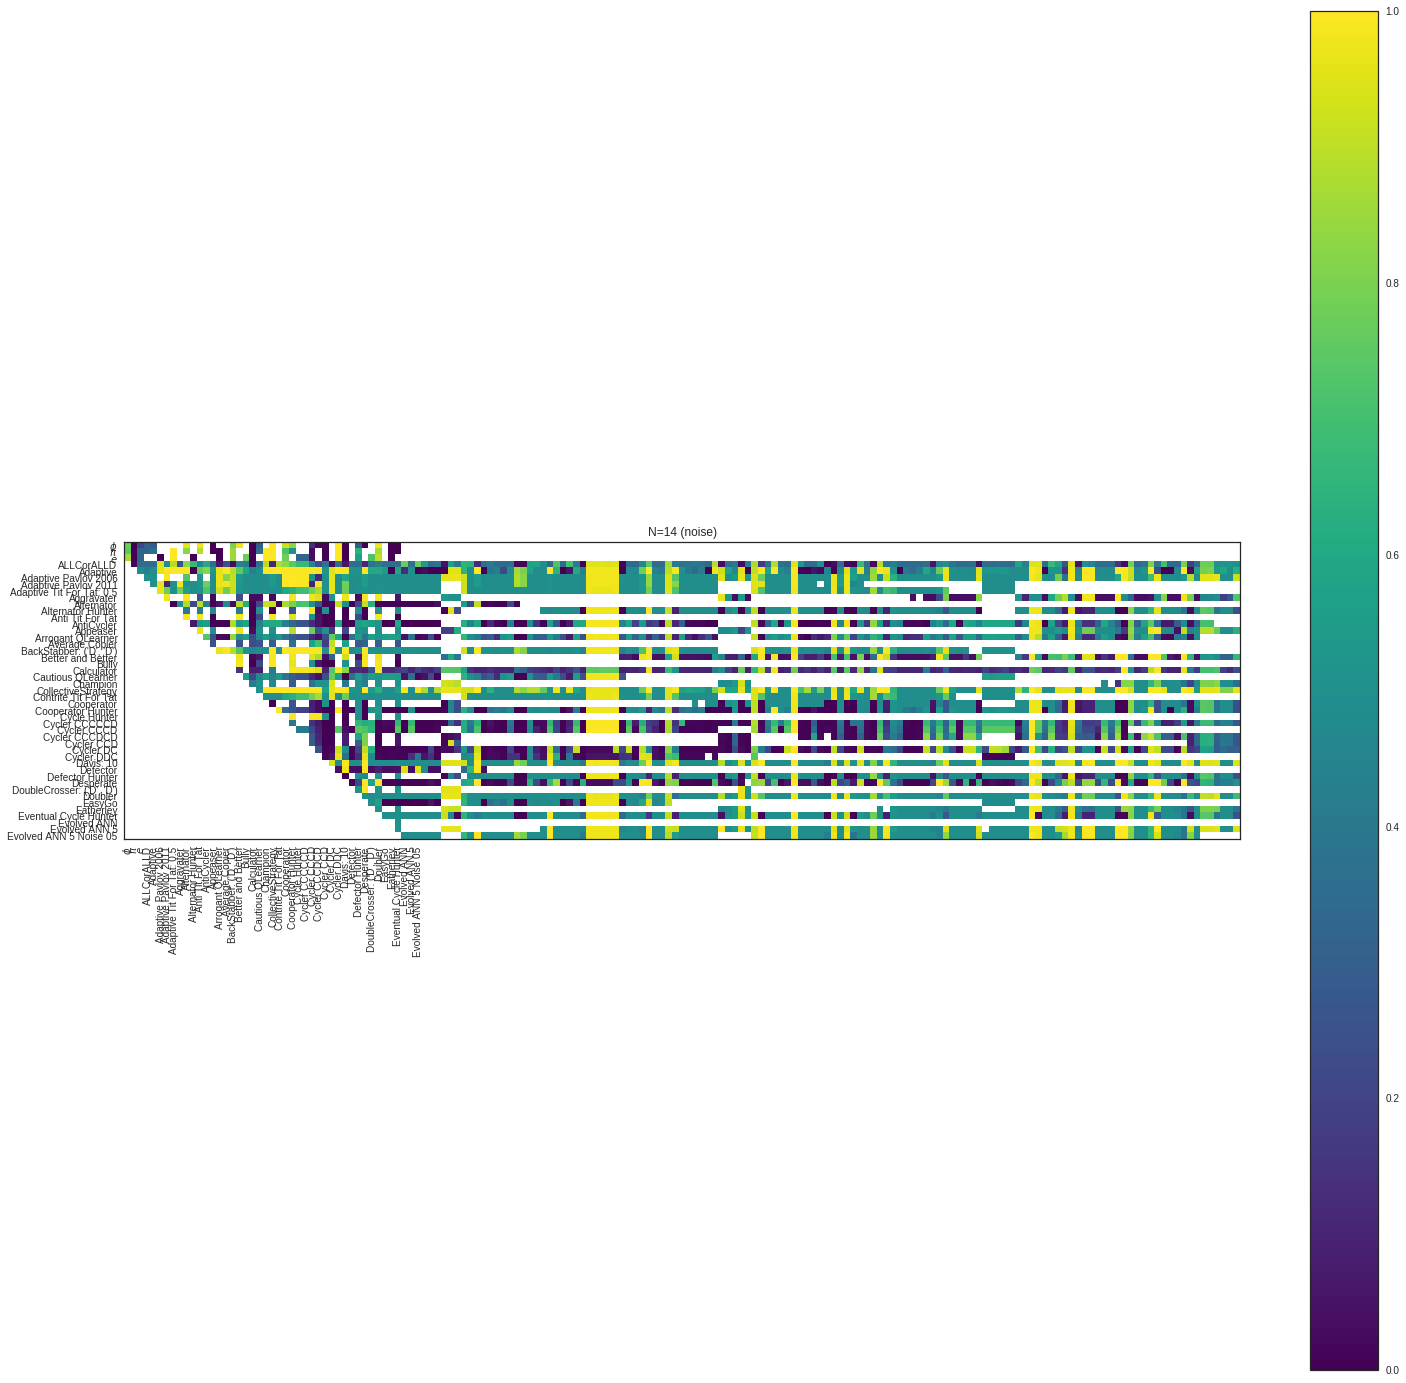

In [184]:
plt.rcParams['figure.figsize'] = 25, 25

for kind in ["std", "noise"]:
    noise_index = summary["Noise"] if kind == "std" else ~summary["Noise"]
    for N in range(2, 14 + 1, 2):
        temp_df = summary[(summary["N"] == N) & noise_index].pivot(index="P1", columns="P2", values="P1 fixation")

        plt.figure()
        plt.imshow(tmp_df, cmap="viridis")
        plt.colorbar()
        plt.yticks(range(len(temp_df.index)), [p[:25] for p in temp_df.index])
        plt.xticks(range(len(temp_df.index)), [p[:25] for p in temp_df.index], rotation='vertical')
        plt.title("N={} ({})".format(N, kind));
        plt.savefig("../img/fixation_heatmap_{}_{}.pdf".format(N, kind))

In [185]:
fix_df = pd.concat([summary[["P1", "P1 fixation", "N", "Noise"]].rename(columns={"P1": "Player", 
                                                                            "P1 fixation": "Fixation"}),
                    summary[["P2", "P2 fixation", "N", "Noise"]].rename(columns={"P2": "Player", 
                                                                            "P2 fixation": "Fixation"})])

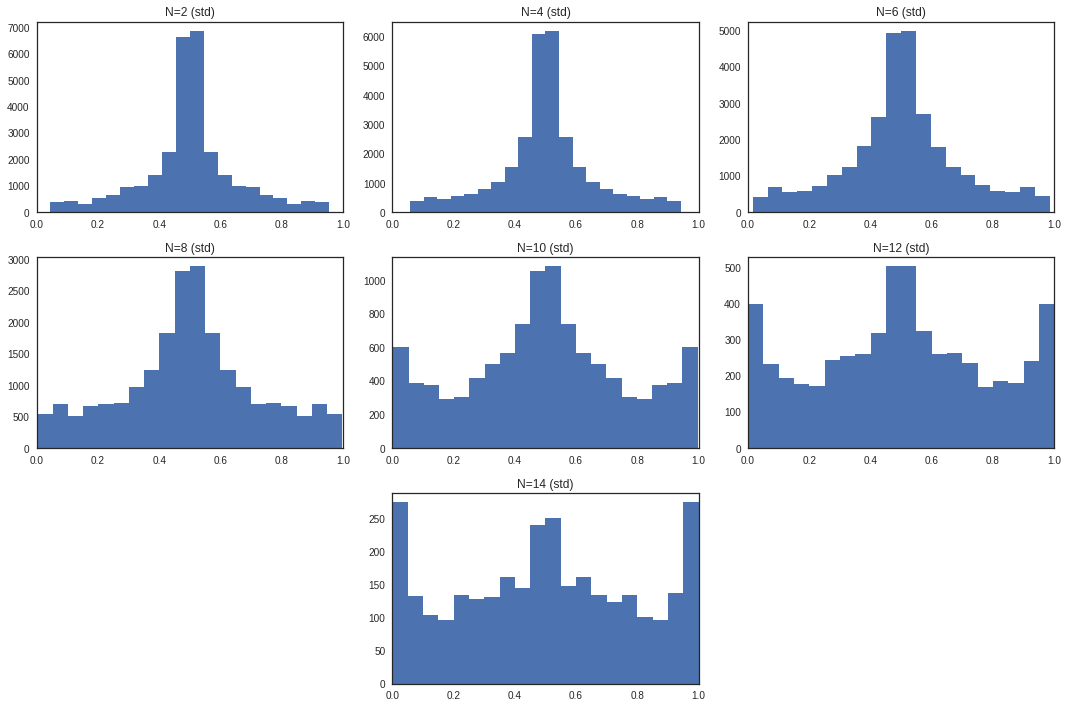

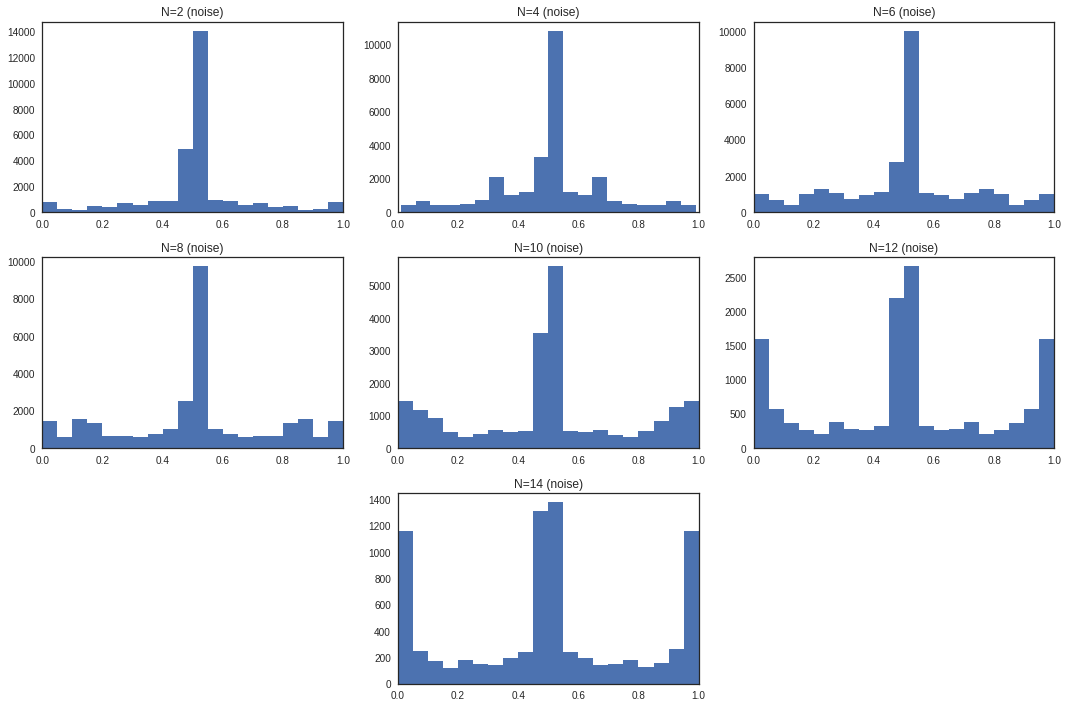

In [186]:
plt.rcParams['figure.figsize'] = 15, 10


for kind in ["std", "noise"]:
    index = fix_df["Noise"] if kind == "std" else ~fix_df["Noise"]
    
    fig, axarr = plt.subplots(3, 3)
    axarr[-1, 0].axis('off')
    axarr[-1, -1].axis('off')
    for n, (N, df) in enumerate(fix_df[index].groupby("N")):
        i = n // 3
        j = n % 3
        if n == 6:
            i, j = -1, 1
        axarr[i, j].hist(df["Fixation"], bins=20)
        axarr[i, j].set_title("N={} ({})".format(N, kind))
        axarr[i, j].set_xlim((0, 1))
        
    fig.tight_layout()
    fig.savefig("../img/histograms_all_fixation_rates_{}.pdf".format(kind))

In [187]:
med_fix = pd.DataFrame(fix_df.groupby(["Player", "N", "Noise"])["Fixation"].median()).reset_index()

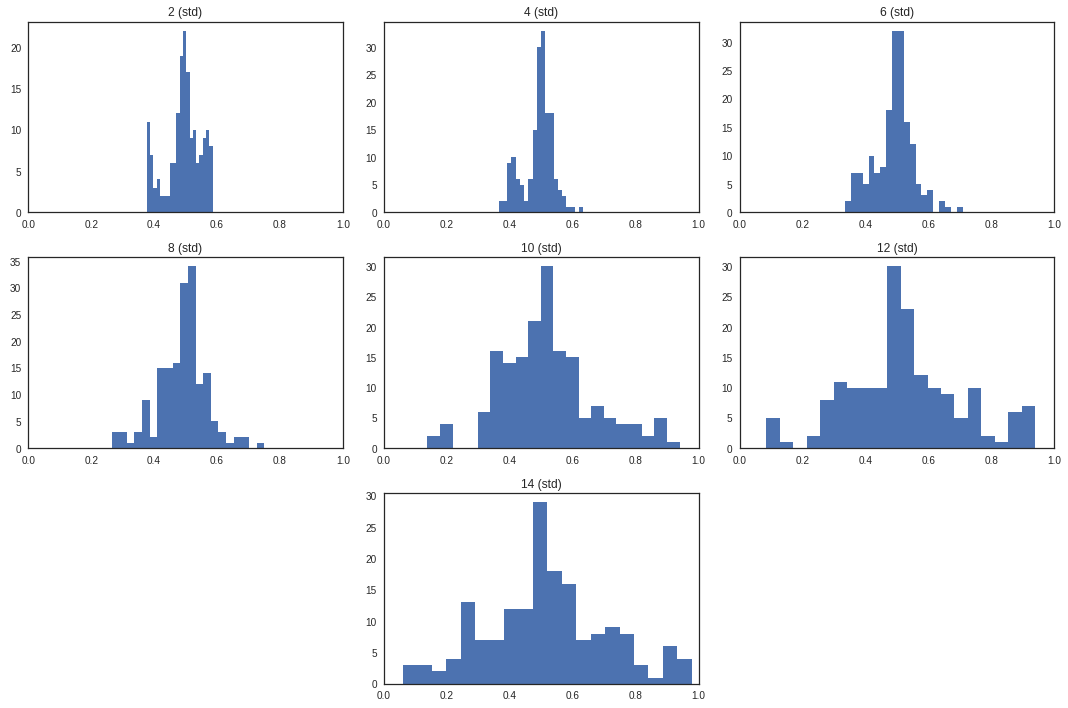

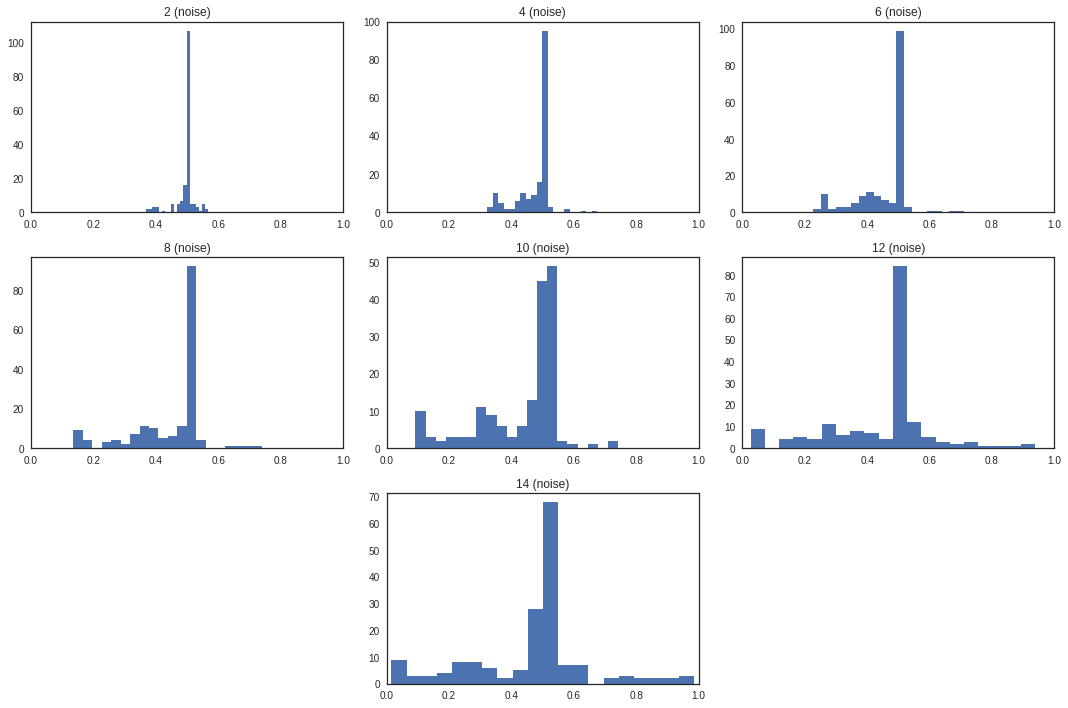

In [188]:
for kind in ["std", "noise"]:
    index = med_fix["Noise"] if kind == "std" else ~med_fix["Noise"]
    
    fig, axarr = plt.subplots(3, 3)
    axarr[-1, 0].axis('off')
    axarr[-1, -1].axis('off')
    for n, (N, df) in enumerate(med_fix[index].groupby("N")):
        i = n // 3
        j = n % 3
        if n == 6:
            i, j = -1, 1
        axarr[i, j].hist(df["Fixation"], bins=20)
        axarr[i, j].set_title("{} ({})".format(N, kind))
        axarr[i, j].set_xlim((0, 1))
        
    fig.tight_layout()
    fig.savefig("../img/histograms_median_fixation_rates_{}.pdf".format(kind))

In [189]:
rank_df = pd.DataFrame()
for N, df in med_fix.groupby(["N"]):
    if "Player" not in rank_df:
        rank_df["Player"] = df[df["Noise"]]["Player"]

    rank_df["std {}".format(N)] = list(df[~df["Noise"]]["Fixation"].rank(ascending=False))
    rank_df["noisy {}".format(N)] = list(df[df["Noise"]]["Fixation"].rank(ascending=False))
rank_df.reset_index(drop=True, inplace=True)

In [190]:
def plot_ranks(noisy=False, max_N=14):
    kind = "noisy" if noisy else "std"
    Ns = range(2, max_N + 1, 2)

    
    fig, ax1 = plt.subplots()    
    
    sorted_df = rank_df.sort_values("{} 2".format(kind), ascending=False)
    ranks, labels = list(zip(*enumerate(sorted_df["Player"])))
    labels = [l[:25] for l in labels]
    sorted_df = rank_df.sort_values("{} {}".format(kind, Ns[-1]), ascending=False)
    last_labels = [l[:25] for l in list(sorted_df["Player"])]
        
    for ax, labels in zip([ax1, ax1.twinx()], [labels, last_labels]):
        ax.set_ylim([min(ranks) - 5, max(ranks) + 5])
        ax.set_yticks(ranks)
        ax.set_yticklabels(labels)
    
    for _, row in sorted_df.iterrows():
        ax1.plot(list(row[["{} {}".format(kind, N) for N in Ns]]))

    ax1.set_xticklabels([0] + list(Ns))
    ax1.set_title("Median ranks of Players ({})".format(kind))
    
    return fig

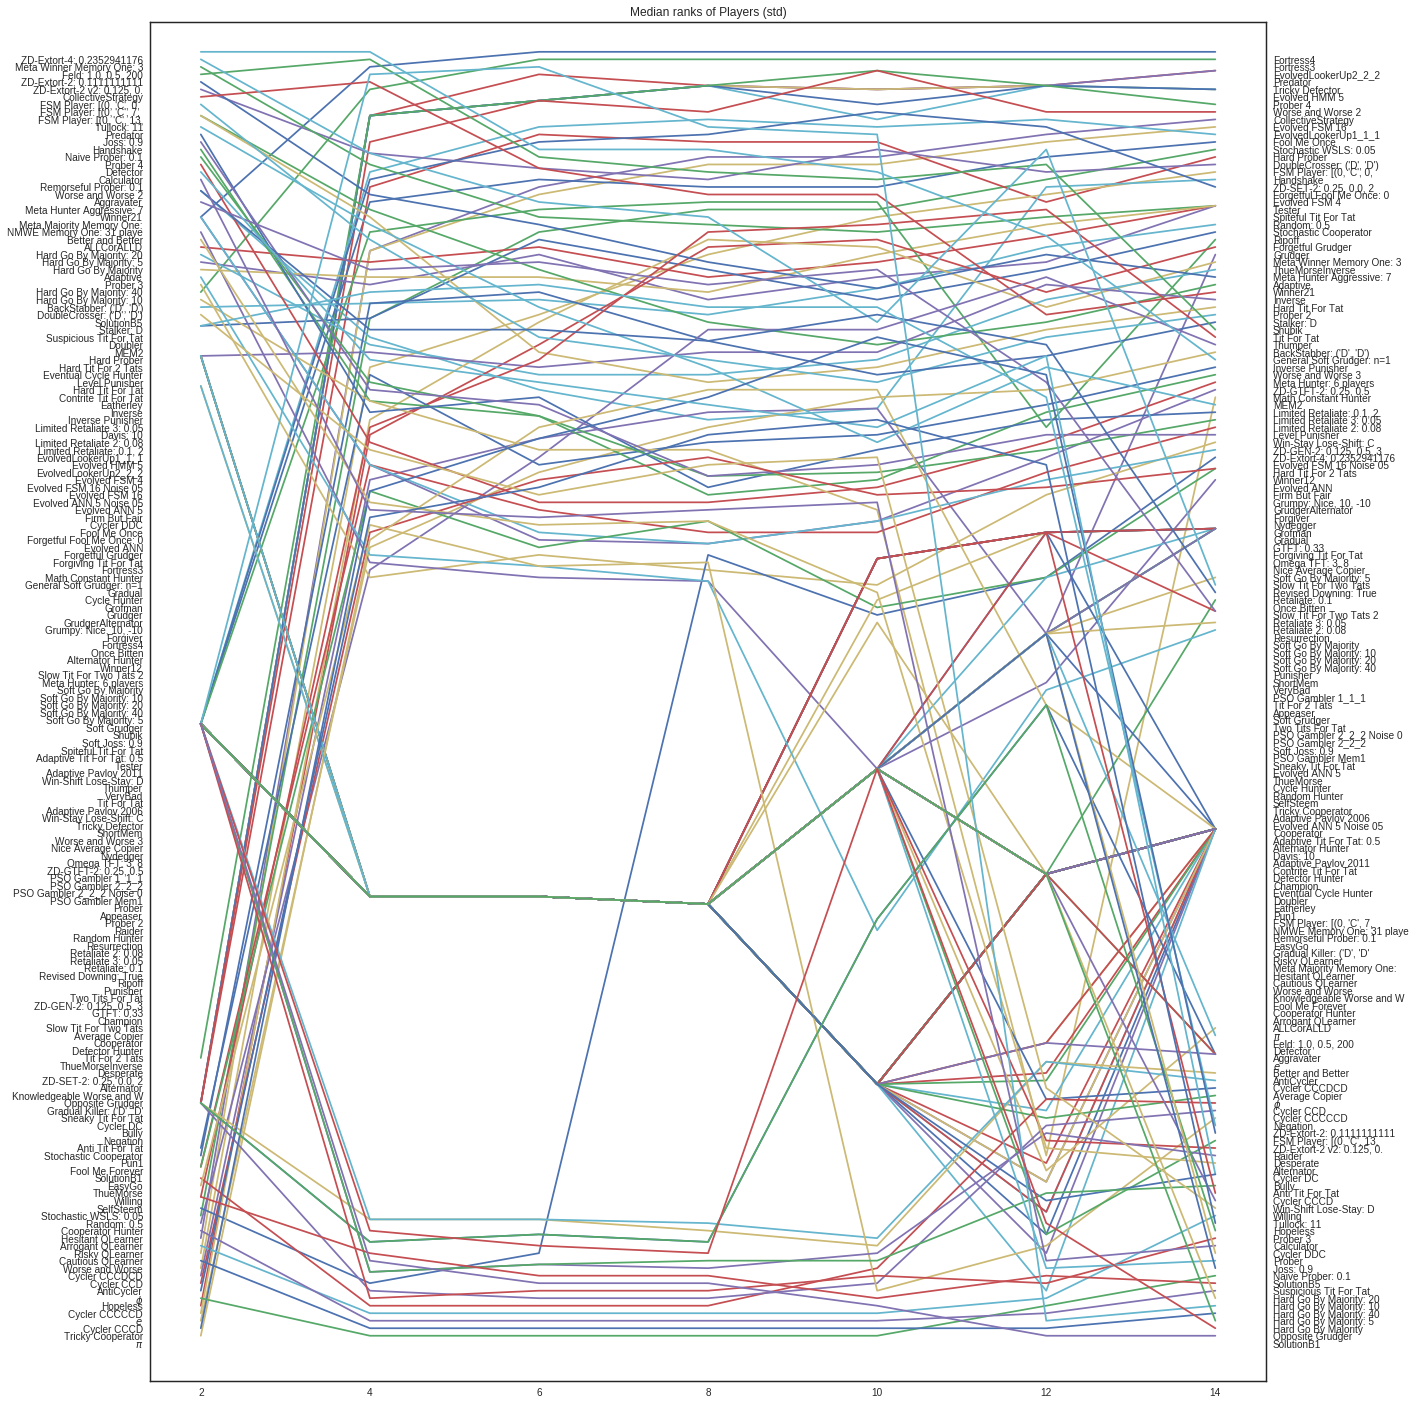

In [191]:
plt.rcParams['figure.figsize'] = 20, 25
p = plot_ranks()
p.savefig("../img/median_rank_vs_population_size_std.pdf")

In [192]:
p = plot_ranks(noisy=True)
p.savefig("../img/median_rank_vs_population_size_noisy.pdf")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Let us take a closer look at the strategies that did well for small population size:

In [193]:
def create_sorted_df(col="std 2"):
    keep, drop = ("std", "noisy") if "std" in col else ("noisy", "std")
    temp_df = rank_df.loc[rank_df.sort_values(col).index]
    temp_df.drop(["{} {}".format(drop, N) for N in range(2, 14 + 1, 2)], axis=1, inplace=True)
    temp_df.rename(columns={"{} {}".format(keep, N): N for N in range(2, 14 + 1, 2)}, inplace=True)
    return temp_df

How do the ranks of the **top 5** in $N=2$ (standard) vary:

In [194]:
temp_df = create_sorted_df()
with open("../tbl/top_five_in_size_2_std.tex", "w") as f:
    f.write(temp_df.head().to_latex(index=False))
temp_df.head()

Player    2      4      6      8  \
168  ZD-Extort-4: 0.23529411764705882, 0.25, 1  1.0  107.0  122.0  127.0   
96          Meta Winner Memory One: 31 players  2.0  113.5  120.5  126.0   
54                         Feld: 1.0, 0.5, 200  3.0  106.0  116.0  122.0   
167       ZD-Extort-2: 0.1111111111111111, 0.5  4.0  123.0  136.0  147.0   
166              ZD-Extort-2 v2: 0.125, 0.5, 1  5.0  121.0  133.0  146.0   

        10     12     14  
168  127.0   85.0   68.5  
96   134.0  129.0   28.0  
54   126.0  127.0  132.0  
167  146.0  138.0  144.0  
166  147.0  140.0  146.0

How do the ranks of the **bottom 5** in $N=2$ (standard) vary:

In [195]:
with open("../tbl/bottom_five_in_size_2_std.tex", "w") as f:
    f.write(temp_df.tail().to_latex(index=False).replace("textbackslashpi", "pi").replace("\\$", "$"))
temp_df.tail()

Player      2      4      6      8     10     12     14
27       Cycler CCCCCD  168.0  153.0  149.0  144.0  140.5  145.0  142.0
2                  $e$  169.0  171.0  158.0  156.0  155.0  157.0  135.0
28         Cycler CCCD  170.0  157.0  150.0  149.0  148.0  150.0  151.5
153  Tricky Cooperator  171.0  158.5  152.0  150.0  136.0  159.0  101.0
1                $\pi$  172.0  172.0  159.0  159.0  156.0  147.5  131.0

How do the ranks of the **top 5** in $N=14$ (standard) vary:

In [196]:
temp_df = create_sorted_df(col="std 14")
with open("../tbl/top_five_in_size_14_std.tex", "w") as f:
    f.write(temp_df.head().to_latex(index=False))
temp_df.head()

Player     2      4      6      8     10    12   14
63              Fortress4  82.5   11.0    8.0    8.0    5.0   1.0  1.0
62              Fortress3  82.5   15.0   13.0   12.0   76.5  16.0  2.0
50   EvolvedLookerUp2_2_2  82.5   59.5   59.5   58.5   76.5  62.5  3.0
109              Predator  11.0    2.0    2.0    2.0    2.0   2.0  4.0
154       Tricky Defector  82.5  169.0  170.0  162.0  161.0   3.0  5.0

How do the ranks of the **bottom 5** in $N=14$ (standard) vary:

In [197]:
with open("../tbl/bottom_five_in_size_14_std.tex", "w") as f:
    f.write(temp_df.tail().to_latex(index=False))
temp_df.tail()

Player      2      4      6      8     10     12     14
76   Hard Go By Majority: 40   32.0  163.5  165.5  167.5  167.0  167.5  167.0
77    Hard Go By Majority: 5   32.0  163.5  165.5  167.5  167.0  167.5  169.5
73       Hard Go By Majority   32.0  163.5  169.0  167.5  167.0  167.5  169.5
104         Opposite Grudger  140.0  167.0  171.0  171.0  171.0  171.0  171.0
140               SolutionB1  150.0  170.0  172.0  172.0  172.0  172.0  172.0

How do the ranks of the **top 5** in $N=2$ (noisy) vary:

In [198]:
temp_df = create_sorted_df("noisy 2")
with open("../tbl/top_five_in_size_2_noisy.tex", "w") as f:
    f.write(temp_df.head().to_latex(index=False))
temp_df.head()

Player    2     4     6     8  \
91                                                MEM2  1.0  16.0  23.0  18.0   
51   FSM Player: [(0, 'C', 0, 'C'), (0, 'D', 3, 'C'...  2.0  28.0  46.0  29.0   
121                                  Retaliate 2: 0.08  3.5  19.5  43.0  33.5   
123                                     Retaliate: 0.1  3.5  23.0  39.5  48.5   
109                                           Predator  5.0  34.0  51.5  43.0   

       10     12     14  
91    5.0    2.0    5.5  
51    9.0   42.0   13.0  
121  48.0   63.0   63.0  
123  78.5  113.0  115.0  
109  36.0   18.5   14.0

How do the ranks of the **bottom 5** in $N=2$ (noisy) vary:

In [199]:
with open("../tbl/bottom_five_in_size_2_noisy.tex", "w") as f:
    f.write(temp_df.tail().to_latex(index=False))
temp_df.tail()

Player      2      4      6      8     10     12     14
14  Arrogant QLearner  168.0  162.0  163.0  158.0  152.0  145.0  155.5
20  Cautious QLearner  170.0  158.0  165.0  156.0  153.0  138.0  138.0
25  Cooperator Hunter  170.0  157.0  146.0  143.0  135.0  141.0  127.0
81  Hesitant QLearner  170.0  162.0  164.0  159.0  134.0  129.0  121.0
27      Cycler CCCCCD  172.0  172.0  167.0  165.0  166.0  157.5  152.0

How do the ranks of the **top 5** in $N=14$ (noisy) vary:

In [200]:
temp_df = create_sorted_df("noisy 14")
with open("../tbl/top_five_in_size_14_noisy.tex", "w") as f:
    f.write(temp_df.head().to_latex(index=False))
temp_df.head()

Player     2      4      6      8     10    12   14
106  PSO Gambler 2_2_2  92.0  115.0  101.0   40.0   13.0   4.0  1.0
112           Prober 3  43.0  139.0  151.0  154.0  112.0   7.0  2.0
154    Tricky Defector  96.5  121.0  118.5  111.0   41.0  60.0  3.0
110             Prober  55.0  142.0  152.0  163.0  158.0  54.0  4.0
57        Fool Me Once   9.0   11.5   18.0   28.0    2.0   6.0  5.5

How do the ranks of the **bottom 5** in $N=14$ (noisy) vary:

In [201]:
with open("../tbl/bottom_five_in_size_14_noisy.tex", "w") as f:
    f.write(temp_df.tail().to_latex(index=False))
temp_df.tail()

Player     2      4      6      8     10     12     14
74  Hard Go By Majority: 10  65.0  141.0  159.0  168.0  168.0  168.0  168.0
75  Hard Go By Majority: 20  72.5  145.5  162.0  167.0  170.0  169.5  169.0
77   Hard Go By Majority: 5  75.0  151.0  168.0  171.0  169.0  169.5  170.0
76  Hard Go By Majority: 40  71.0  149.0  169.5  170.0  171.0  171.0  171.0
73      Hard Go By Majority  76.0  159.0  172.0  172.0  172.0  172.0  172.0

How does the memory size of a strategy effect the median rank?

In [211]:
median_rank_v_mem = pd.merge(rank_df, player_info, on="Player").groupby("Memory Depth").median().reset_index()

In [212]:
tmp_df = median_rank_v_mem.drop([*["noisy {}".format(N) for N in range(2, 14 + 1, 2)], 
                                "Stochastic"], axis=1)
tmp_df.rename(columns={"std {}".format(N): N for N in range(2, 14 + 1, 2)}, inplace=True)
tmp_df.sort_values(14, inplace=True)
with open("../tbl/median_rank_v_memory_length_std.tex", "w") as f:
    f.write(tmp_df.to_latex(index=False).replace("-1", "$\infty$"))
tmp_df

Memory Depth       2       4       6       8      10      12      14
8              9   11.00    2.00    2.00    2.00    2.00    2.00    4.00
5              4   82.50   35.25   33.75   33.25   40.75   54.50   10.50
12            16   82.50   59.50   59.50   58.50   76.50   78.50   39.25
0             -1   82.50   59.50   59.50   58.50   76.50   73.75   68.50
3              2   82.50   59.50   59.50   58.50   34.50   62.50   68.50
7              6   82.50   59.50   59.50   58.50   34.50   62.50   68.50
9             10   82.50   59.50   59.50   58.50   76.50   62.50   68.50
11            12   82.50   59.50   59.50   58.50   34.50   62.50   68.50
4              3   82.50   59.50   59.50   58.50   76.50   78.50   88.50
1              0  131.50  103.00  118.00  125.00  122.00  131.50  108.50
13            20   57.25  111.50  112.50  113.00  120.75  115.00  117.75
14            40   57.25  111.50  112.50  113.00  121.75  115.00  117.75
2              1   82.50  119.00  120.50  123.00  124.50  117.00  130.00
15           200    3.00  106.00  116.00  122.00  126.00  127.00  132.00
6              5   82.50  151.50  140.50  136.00  135.25  140.00  140.00
10            11   10.00  130.00  137.00  145.00  150.00  153.00  156.00

In [213]:
tmp_df = median_rank_v_mem.drop([*["std {}".format(N) for N in range(2, 14 + 1, 2)], 
                                "Stochastic"], axis=1)
tmp_df.rename(columns={"noisy {}".format(N): N for N in range(2, 14 + 1, 2)}, inplace=True)
tmp_df.sort_values(14, inplace=True)
with open("../tbl/median_rank_v_memory_length_noisy.tex", "w") as f:
    f.write(tmp_df.to_latex(index=False).replace("-1", "$\infty$"))
tmp_df

Memory Depth       2       4       6       8      10      12      14
8              9    5.00   34.00   51.50   43.00   36.00   18.50   14.00
12            16   57.75   51.25   51.50   36.00   10.50   14.50   31.75
7              6  103.00   85.00   75.00   73.00   56.00   59.00   53.00
5              4   89.25   60.50   65.50   64.50   55.00   24.00   62.50
0             -1   77.00   77.50   76.75   75.75   71.00   68.00   69.50
1              0  126.50  125.00  125.00  103.50  101.00   68.00   88.00
2              1  100.00  102.00  103.00  101.00   95.00  100.50   92.50
9             10  106.00   40.50   47.00   54.00   71.00   80.00   98.50
15           200   34.00   54.00   55.50   62.50   69.00   79.00   98.50
4              3  110.75   63.00   63.50   76.00  116.00   97.75   98.75
14            40   91.50   96.50   96.75   97.75  115.00  118.50  115.00
3              2   85.25   76.50   90.25   89.50  114.25  113.00  120.50
13            20   89.25   94.25   96.00   96.25  110.50  128.75  125.00
11            12   70.00   11.50   12.00   73.00  121.00  130.00  134.00
6              5   89.00  134.50  127.75  135.00  131.25  135.50  136.00
10            11   44.50  111.00  129.00  144.00  150.00  146.00  159.00

Let us take a look at the relationship between the different rankings (does a player who ranks highly in a small population rank highly in a big population?).

In [214]:
rank_df.head()

Player  std 2  noisy 2  std 4  noisy 4  std 6  noisy 6  std 8  noisy 8  \
0      $\phi$  166.0    152.0  168.0    162.0  156.5    153.5  153.0    161.0   
1       $\pi$  172.0    166.5  172.0    171.0  159.0    169.5  159.0    146.0   
2         $e$  169.0    163.0  171.0    168.0  158.0    158.0  156.0    157.0   
3  ALLCorALLD   26.0     98.0  129.0    107.0  117.0    109.5  120.0    101.0   
4    Adaptive   32.0     52.0    7.0     15.0    6.0      9.0    6.0      8.0   

   std 10  noisy 10  std 12  noisy 12  std 14  noisy 14  
0   153.0     144.0   137.0     128.0   140.0     146.0  
1   156.0     120.0   147.5      41.0   131.0      55.0  
2   155.0     113.5   157.0     160.0   135.0     151.0  
3   121.0     103.5   125.0     103.5   130.0      95.5  
4     8.0      33.0    29.0      34.0    31.0      32.0

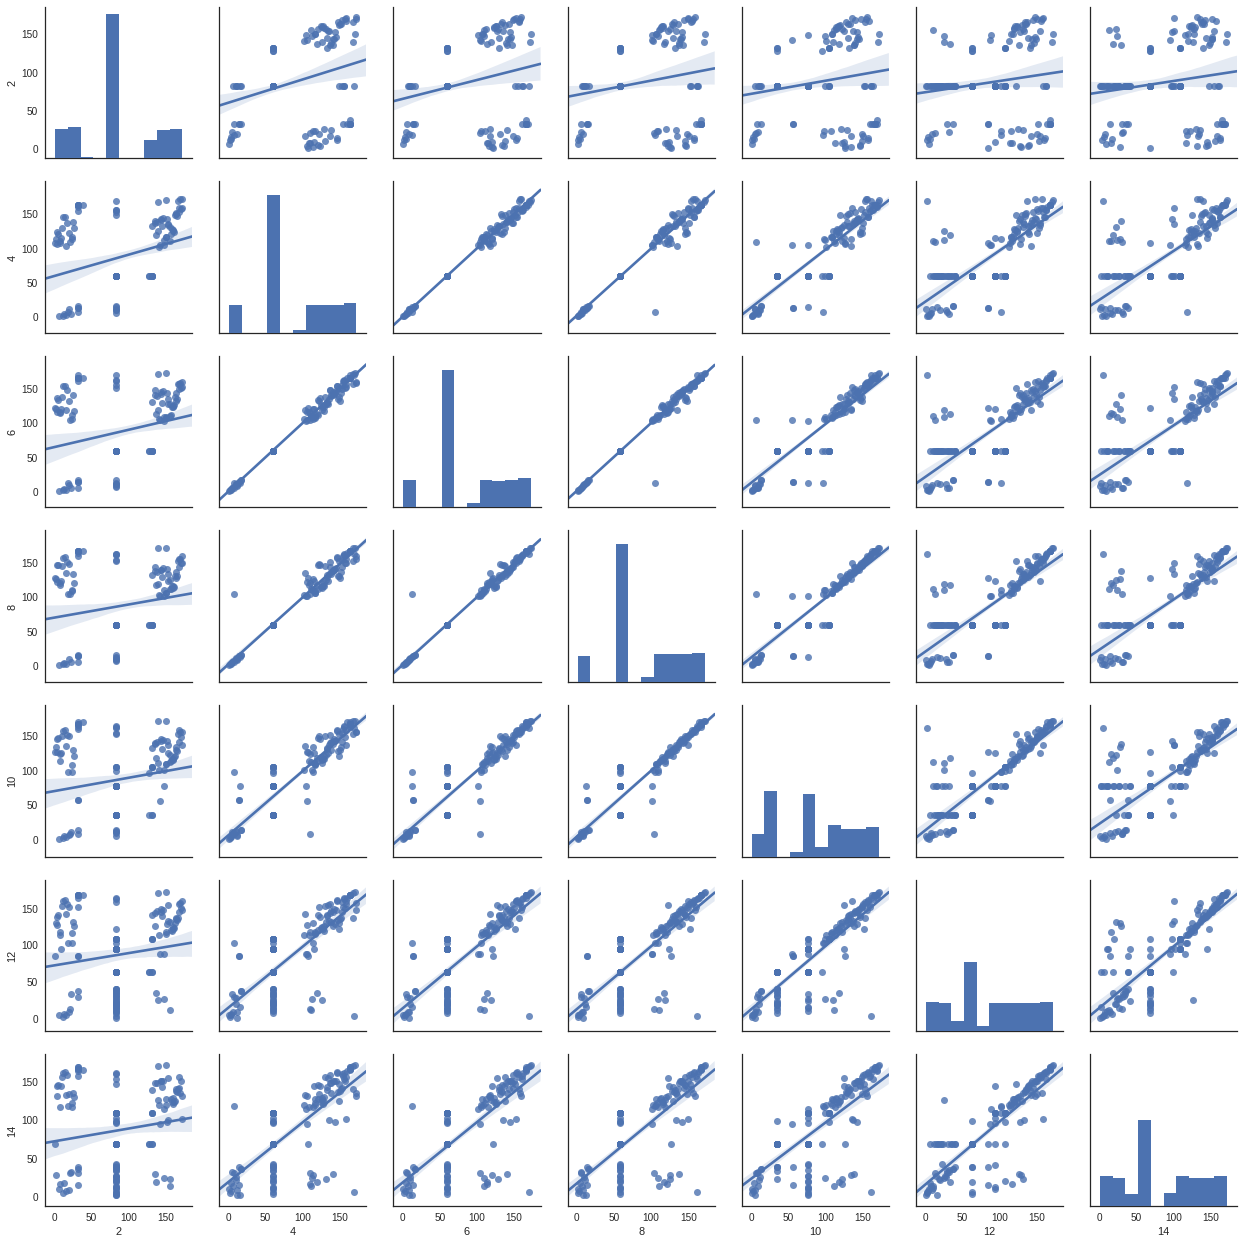

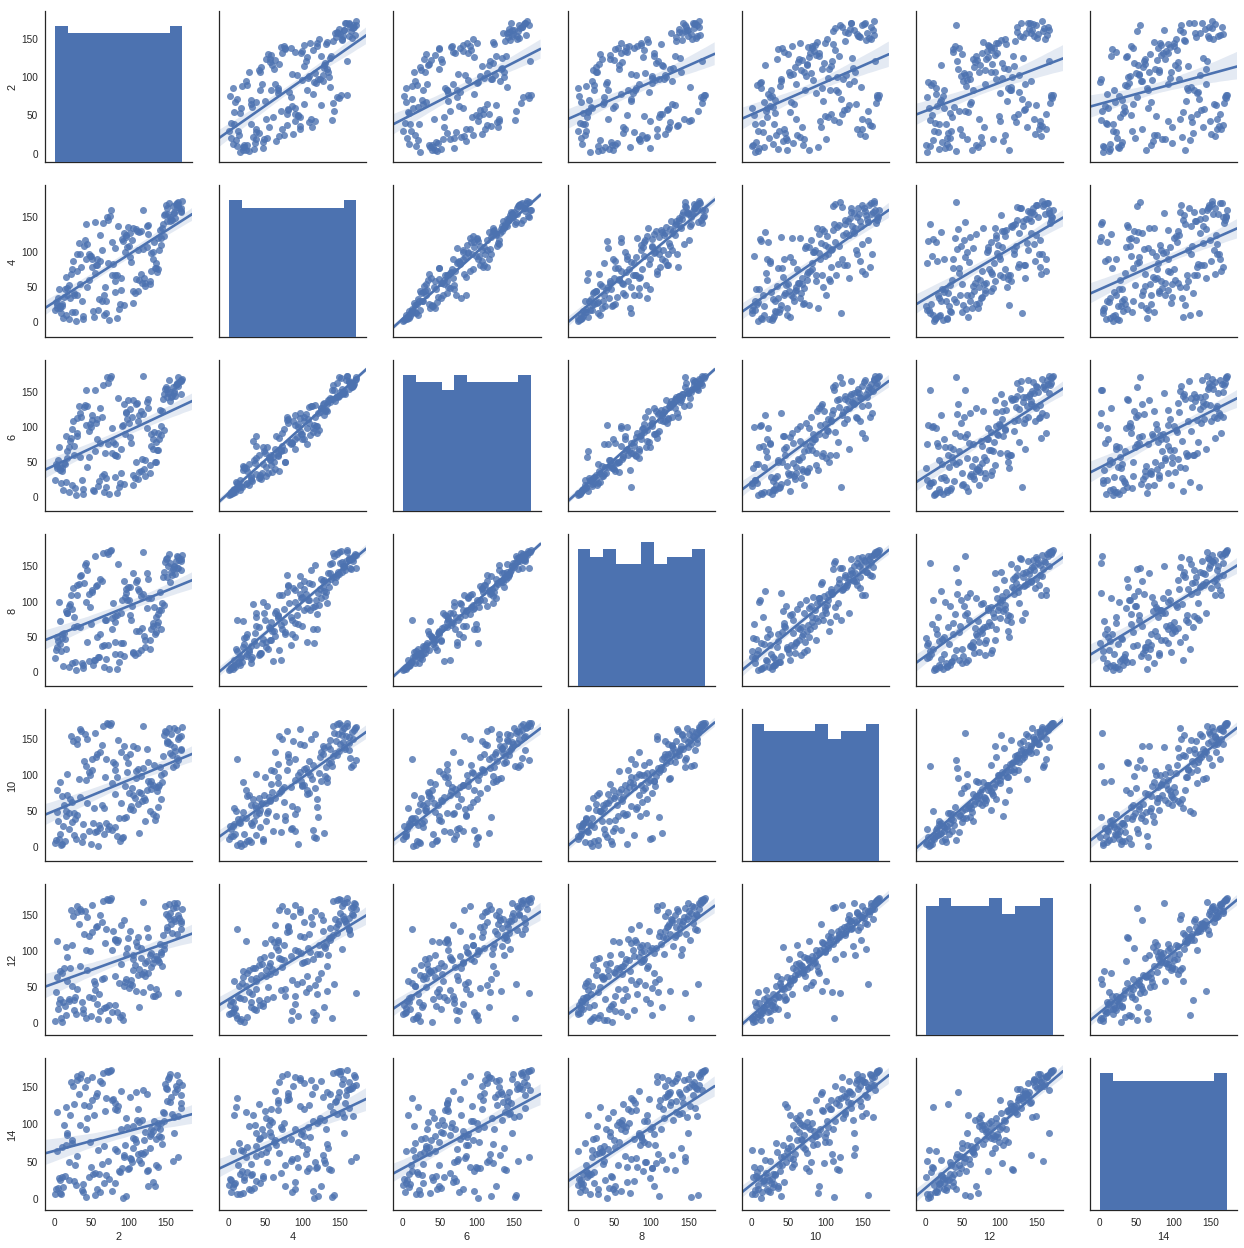

In [215]:
for kind in ["std", "noisy"]:
    keep = kind
    drop = "noisy" if kind == "std" else "std"
    
    tmp_df = rank_df.drop(["{} {}".format(drop, N) for N in range(2, 14 + 1, 2)], axis=1)
    tmp_df.rename(columns={"{} {}".format(keep, N): N for N in range(2, 14 + 1, 2)}, inplace=True)
    
    p = sns.pairplot(tmp_df, kind="reg")
    p.savefig("../img/relationship_between_median_ranks_{}.pdf".format(kind))